In [1]:
!pip install xgboost shap rpy2 linearmodels --quiet


In [2]:
# Standard library imports
import os
import re

# Data analysis
import pandas as pd
import numpy as np

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    GroupKFold,
    cross_val_score,
)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.model_selection import RandomizedSearchCV

# Statistical modeling 
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, RandomEffects, compare
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# EXplainability and XGBOOST model as well as R Library
import xgboost as xgb
import shap
import rpy2
from xgboost import XGBRegressor



## Load Data

In [4]:
# Define file paths for raw datasets
base_root = '../data/raw'

file_paths = {
    'capital': os.path.join(base_root, 'CapitalStockData.csv'),
    'energy': os.path.join(base_root, 'energy_use.csv'),
    'labor_force': os.path.join(base_root, 'labor_force.csv'),
    'patents': os.path.join(base_root, 'patents_res_nonres.csv'),
    'rnd': os.path.join(base_root, 'R&D.csv'),
    'unemployment': os.path.join(base_root, 'unemployed_ilo_estimate.csv'),
    'population': os.path.join(base_root, 'population_Data.csv'),
    'human_capital': os.path.join(base_root, 'Human_Capital_Data.csv'),
    'penn_table': os.path.join(base_root, 'penn_table.csv'),
}

# Validate that all files exist
for name, path in file_paths.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Data file not found: {path}")

In [5]:
# Load datasets into a dictionary of DataFrames
dfs = {}
for name, path in file_paths.items():
    try:
        dfs[name] = pd.read_csv(path)
        print(f"Loaded {name}_df: {dfs[name].shape[0]} rows, {dfs[name].shape[1]} columns")
    except Exception as e:
        raise ValueError(f"Failed to load {path}: {str(e)}")

# # Display the first few rows of each DataFrame for inspection
# for name, df in dfs.items():
#     print(f"\n{name}_df (first 5 rows):")
#     display(df.head())

Loaded capital_df: 11640 rows, 18 columns
Loaded energy_df: 266 rows, 68 columns
Loaded labor_force_df: 266 rows, 68 columns
Loaded patents_df: 532 rows, 68 columns
Loaded rnd_df: 266 rows, 68 columns
Loaded unemployment_df: 266 rows, 68 columns
Loaded population_df: 6123 rows, 95 columns
Loaded human_capital_df: 803 rows, 68 columns
Loaded penn_table_df: 12810 rows, 52 columns


In [6]:
# dfs = {name: pd.read_csv(path) for name, path in file_paths.items()}

# # Assign each DataFrame to a variable with _df suffix
# for name, df in dfs.items():
#     globals()[f"{name}_df"] = df

# # Print heads 
# for name in dfs.keys():
#     print(f"{name}_df")


## Wrangle Data

In [8]:
# Inspect the structure of each DataFrame
for name, df in dfs.items():
    if df.empty:
        print(f"\n{name}: Empty DataFrame")
        continue
    print(f"\n{name}:")
    if 'Series Name' in df.columns:
        # Long format: List unique series names
        unique_series = df['Series Name'].dropna().unique().tolist()
        print(f"  Series Names: {unique_series}")
    else:
        # Wide format: List columns, excluding metadata
        skip_cols = {'countrycode', 'ifs', 'currency_unit', 'unnamed'}
        data_columns = [
            col for col in df.columns
            if col.lower() not in skip_cols and not col.lower().startswith('unnamed')
        ]
        print(f"  Columns: {data_columns}")


capital:
  Columns: ['ifscode', 'countryname', 'year', 'igov_rppp', 'kgov_rppp', 'ipriv_rppp', 'kpriv_rppp', 'ippp_rppp', 'kppp_rppp', 'GDP_rppp', 'igov_n', 'kgov_n', 'ipriv_n', 'kpriv_n', 'kppp_n', 'GDP_n', 'income']

energy:
  Series Names: ['Energy use (kg of oil equivalent per capita)']

labor_force:
  Series Names: ['Labor force, total']

patents:
  Series Names: ['Patent applications, nonresidents', 'Patent applications, residents']

rnd:
  Series Names: ['Researchers in R&D (per million people)']

unemployment:
  Series Names: ['Unemployment, total (% of total labor force) (modeled ILO estimate)']

population:
  Series Names: ['Age dependency ratio (% of working-age population)', 'Age dependency ratio, old', 'Age dependency ratio, young', 'Life expectancy at birth, total (years)', 'Life expectancy at birth, male (years)', 'Life expectancy at birth, female (years)', 'Population ages 15-64 (% of total population)', 'Population ages 15-64, female', 'Population ages 15-64, male', '

In [9]:
def process_time_series(
    df: pd.DataFrame,
    id_vars_map: dict,
    year_col: str = 'year',
    cutoff_year: int = 2019,
    drop_id_na_all: bool = True,
    value_name: str = 'value'
):
    # 0a) Rename ID cols + strip "[YR####]" suffixes
    df2 = df.rename(columns=id_vars_map).copy()
    yr_pat = re.compile(r'^(\d{4}) \[YR\d{4}\]$')
    strip  = {c: yr_pat.match(c).group(1)
              for c in df2.columns if yr_pat.match(c)}
    if strip:
        df2 = df2.rename(columns=strip)

    # 1) static IDs
    id_vars = list(id_vars_map.values())

    # 2) Melt → long
    if year_col in df2.columns:
        ivy        = id_vars + [year_col]
        value_vars = [c for c in df2.columns if c not in ivy]
        df_long    = df2.melt(
            id_vars    = ivy,
            value_vars = value_vars,
            var_name   = 'series',
            value_name = value_name
        )
        df_long[year_col] = df_long[year_col].astype(int)
    else:
        year_cols = [c for c in df2.columns if c not in id_vars]
        df_long   = df2.melt(
            id_vars    = id_vars,
            value_vars = year_cols,
            var_name   = year_col,
            value_name = value_name
        )
        df_long[year_col] = df_long[year_col].astype(int)

    # 3) coerce & cutoff
    df_long[value_name] = pd.to_numeric(df_long[value_name], errors='coerce')
    df_long            = df_long[df_long[year_col] <= cutoff_year]

    # 4) drop rows where ALL IDs+year are missing
    if drop_id_na_all:
        df_long = df_long.dropna(subset=id_vars + [year_col], how='all')

    # 5) track missing before
    df_long['_missing_before'] = df_long[value_name].isna()

    # 6) interpolate per group
    if 'series' in df_long:
        group_cols = id_vars + ['series']
        metric_col = 'series'
    else:
        group_cols = id_vars
        metric_col = id_vars[0]
    df_long = df_long.sort_values(group_cols + [year_col])
    df_long[value_name] = (
        df_long
        .groupby(group_cols)[value_name]
        .transform(lambda s: s.interpolate('linear').ffill().bfill())
    )

    # 7) track imputed + leftover
    df_long['_imputed']       = df_long['_missing_before'] & df_long[value_name].notna()
    df_long['_missing_after'] = df_long[value_name].isna()

    # 8) summary
    summary = (
        df_long
        .groupby(metric_col)
        .agg(
            total           =(value_name,      'size'),
            missing_before  =('_missing_before','sum'),
            imputed         =('_imputed',      'sum'),
            missing_after   =('_missing_after','sum'),
        )
        .assign(
            missing_before_pct=lambda d: d['missing_before']/d['total']*100,
            imputed_pct       =lambda d: d['imputed']/d['total']*100,
            missing_after_pct =lambda d: d['missing_after']/d['total']*100,
        )
        .reset_index()
    )
    return df_long, summary


In [10]:
penn_table_df = dfs['penn_table']
# Define the columnns we want to keep from penn_table_df
columns = [
    'countrycode', 'country', 'year',
    'rgdpo',      # Output-side Real GDP at PPP
    'emp',        # Employment
    'avh',        # Average hours worked
    'hc',         # Human capital index
    'cn',         # Capital stock (PPP 2017 US$)
    'ck',         # Capital services (USA=1)
    'ctfp'        # TFP at current PPPs (USA=1)
]

# Create the penn_df

penn_df = penn_table_df[columns].copy()
penn_df = penn_df.rename(columns={
    'countrycode': 'country_code',
    'rgdpo':       'real_gdp_ppp_output',
    'emp':         'employment_million',
    'avh':         'avg_hours_per_year',
    'hc':          'human_capital',
    'cn':          'capital_stock_total',
    'ck':          'capital_services_index',
    'ctfp':        'tfp_index'
})

display(penn_df.head())

,country_code,country,year,real_gdp_ppp_output,employment_million,avg_hours_per_year,human_capital,capital_stock_total,capital_services_index,tfp_index
0,ABW,Aruba,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:

#  Coerce potential object-type numeric columns (like 'avg_hours_per_year') to float
numeric_cols = [
    'real_gdp_ppp_output',
    'employment_million',
    'avg_hours_per_year',
    'human_capital',
    'capital_stock_total',
    'capital_services_index',
    'tfp_index'
]

for col in numeric_cols:
    if col in penn_df.columns:
        penn_df[col] = (
            penn_df[col]
            .astype(str)
            .str.replace(',', '')     # remove commas like '2,034'
            .replace('nan', np.nan)   # handle literal string "nan"
            .astype(float)
        )

# Define the ID mapping
penn_map = {
    'country_code': 'country_code',
    'country':      'country'
}

#  Clean using process_time_series
penn_long, penn_summary = process_time_series(
    df          = penn_df,
    id_vars_map = penn_map,
    year_col    = 'year',
    cutoff_year = 2019
)

#  Pivot to wide format
penn_df_processed = (
    penn_long
    .pivot_table(
        index   = list(penn_map.values()) + ['year'],
        columns = 'series',
        values  = 'value'
    )
    .reset_index()
)

# Display summary
print("\nPenn Table Imputation Summary:")
display(penn_summary)



Penn Table Imputation Summary:


,series,total,missing_before,imputed,missing_after,missing_before_pct,imputed_pct,missing_after_pct
0,avg_hours_per_year,12810,9318,1338,7980,72.740047,10.444965,62.295082
1,capital_services_index,12810,5720,2500,3220,44.652615,19.516003,25.136612
2,capital_stock_total,12810,2496,2286,210,19.484778,17.845433,1.639344
3,employment_million,12810,3281,3211,70,25.612802,25.066354,0.546448
4,human_capital,12810,4173,1513,2660,32.576112,11.811085,20.765027
5,real_gdp_ppp_output,12810,2411,2411,0,18.821233,18.821233,0.000000
6,tfp_index,12810,6403,1853,4550,49.984387,14.465262,35.519126


In [12]:
# Rename the raw DF
capital_df = dfs['capital']
capital_df = capital_df.rename(columns={
    'countryname': 'country',
    'countrycode': 'country_code',
    'income':      'income_group'
})

# # count before dropping missing-target
# print("Rows before dropping missing GDP_rppp:", len(capital_df))

# # Drop any rows where our target GDP_rppp is NaN
# capital_df = capital_df[capital_df['GDP_rppp'].notna()].copy()

# # count after
# print("Rows after dropping missing GDP_rppp: ", len(capital_df))

# Now include income in your static IDs so it is *not* melted as a series
cap_map = {
    'countrycode': 'country_code',   
    'ifscode':     'ifscode',
    'country':     'country',
    'income':      'income_group'
}

cap_long, cap_summary = process_time_series(
    capital_df,
    id_vars_map = cap_map,
    year_col    = 'year',
    cutoff_year = 2019   # we have target variable only up to 2019
)

# pivot back if you like:
capital_df_processed = (
    cap_long
    .pivot_table(
        index   = list(cap_map.values()) + ['year'],
        columns = 'series',
        values  = 'value'
    )
    .reset_index()
)

print("\nAfter imputation summary:")
display(cap_summary)



After imputation summary:


,series,total,missing_before,imputed,missing_after,missing_before_pct,imputed_pct,missing_after_pct
0,GDP_n,11640,1344,1344,0,11.546392,11.546392,0.000000
1,GDP_rppp,11640,1356,1296,60,11.649485,11.134021,0.515464
2,igov_n,11640,3676,2476,1200,31.580756,21.271478,10.309278
3,igov_rppp,11640,1350,90,1260,11.597938,0.773196,10.824742
4,ippp_rppp,11640,6766,3646,3120,58.127148,31.323024,26.804124
5,ipriv_n,11640,3676,2476,1200,31.580756,21.271478,10.309278
6,ipriv_rppp,11640,1350,90,1260,11.597938,0.773196,10.824742
7,kgov_n,11640,3465,2505,960,29.768041,21.520619,8.247423
8,kgov_rppp,11640,1099,79,1020,9.441581,0.678694,8.762887
9,kppp_n,11640,6836,3596,3240,58.728522,30.893471,27.835052


In [13]:
# Extract other DataFrames from dfs based on wb_dfs keys
energy_df = dfs['energy']
labor_force_df = dfs['labor_force']
patents_df = dfs['patents']
rnd_df = dfs['rnd']
unemployment_df = dfs['unemployment']
population_df = dfs['population']
human_capital_df = dfs['human_capital']

# Define column renaming map for World Bank-style tables
wb_map = {
    'Series Name':  'series_name',
    'Series Code':  'series_code',
    'Country Name': 'country',
    # 'Country Code': 'country_code',  # Excluded as redundant in many cases
    # 'countrycode':  'country_code'
}

# Bundle raw World Bank-style tables
wb_dfs = {
    'energy':        energy_df,
    'labor_force':   labor_force_df,
    'patents':       patents_df,
    'rnd':           rnd_df,
    'unemployment':  unemployment_df,
    'population':    population_df,
    'human_capital': human_capital_df,
}

# Verify the extraction by printing the shape of each DataFrame
for name, df in wb_dfs.items():
    print(f"{name}_df: {df.shape[0]} rows, {df.shape[1]} columns")

energy_df: 266 rows, 68 columns
labor_force_df: 266 rows, 68 columns
patents_df: 532 rows, 68 columns
rnd_df: 266 rows, 68 columns
unemployment_df: 266 rows, 68 columns
population_df: 6123 rows, 95 columns
human_capital_df: 803 rows, 68 columns


In [14]:
# Pre‐clean each DF: unify & drop any countrycode variants

cleaned = {}
for name, df in wb_dfs.items(): # if there's a 'Country Code' or 'countrycode' column, drop it:
    df_cleaned = df.drop(columns=[col for col in ['Country Code', 'countrycode'] if col in df.columns])
    cleaned[name] = df_cleaned
   

In [15]:
# Process all of them exactly as before
processed = {}
summaries = {}
for name, df in cleaned.items():
    long_filled, summary = process_time_series(
        df,
        id_vars_map = wb_map,
        year_col    = 'year',
        cutoff_year = 2019
    )
    processed[name]  = long_filled
    summaries[name]  = summary


In [16]:
id_cols = ['series_name', 'country']

processed_clean = {}

for name, long_df in processed.items():
    initial_len = len(long_df)
    missing_rows = long_df[id_cols].isna().all(axis=1).sum()

    print(f"\n{name.upper()} dataset:")
    print(f"Initial rows: {initial_len}, Missing ID rows: {missing_rows}")

    df_clean = long_df.dropna(subset=id_cols, how='all')
    dropped_rows = initial_len - len(df_clean)
    print(f"Rows after dropping: {len(df_clean)}, Dropped rows: {dropped_rows}")

    processed_clean[name] = df_clean

    wide_df = df_clean.pivot(index=['country', 'year'], columns='series_name', values='value').reset_index()
    wide_df.columns.name = None
    wide_df.columns = wide_df.columns.astype(str)

    # Explicit assignment, avoid globals()
    locals()[f"{name}_df_processed"] = wide_df



ENERGY dataset:
Initial rows: 15960, Missing ID rows: 0
Rows after dropping: 15960, Dropped rows: 0

LABOR_FORCE dataset:
Initial rows: 15960, Missing ID rows: 0
Rows after dropping: 15960, Dropped rows: 0

PATENTS dataset:
Initial rows: 31920, Missing ID rows: 0
Rows after dropping: 31920, Dropped rows: 0

RND dataset:
Initial rows: 15960, Missing ID rows: 0
Rows after dropping: 15960, Dropped rows: 0

UNEMPLOYMENT dataset:
Initial rows: 15960, Missing ID rows: 0
Rows after dropping: 15960, Dropped rows: 0

POPULATION dataset:
Initial rows: 367380, Missing ID rows: 180
Rows after dropping: 367200, Dropped rows: 180

HUMAN_CAPITAL dataset:
Initial rows: 48180, Missing ID rows: 180
Rows after dropping: 48000, Dropped rows: 180


In [17]:
wide_dfs = {
    'capital': capital_df_processed,
    'energy': energy_df_processed,
    'labor_force': labor_force_df_processed,
    'patents': patents_df_processed,
    'rnd': rnd_df_processed,
    'unemployment': unemployment_df_processed,
    'population': population_df_processed,
    'human_capital': human_capital_df_processed,
    'penn': penn_df_processed,
}

for name, df in wide_dfs.items():
    print(f"\n{name.upper()} dataset (rows={len(df)}):")

    missing_info = pd.DataFrame({
        'missing_count': df.isna().sum(),
        'missing_pct': (df.isna().mean() * 100).round(2)
    })
    display(missing_info.sort_values(by='missing_pct', ascending=False).head(10))



CAPITAL dataset (rows=11640):


,missing_count,missing_pct
series,,
kppp_rppp,3240,27.84
kppp_n,3240,27.84
ippp_rppp,3120,26.80
igov_rppp,1260,10.82
ipriv_rppp,1260,10.82
ipriv_n,1200,10.31
igov_n,1200,10.31
kgov_rppp,1020,8.76
kpriv_rppp,1020,8.76



ENERGY dataset (rows=15960):


,missing_count,missing_pct
Energy use (kg of oil equivalent per capita),2760,17.29
country,0,0.00
year,0,0.00



LABOR_FORCE dataset (rows=15960):


,missing_count,missing_pct
"Labor force, total",1860,11.65
country,0,0.00
year,0,0.00



PATENTS dataset (rows=15960):


,missing_count,missing_pct
"Patent applications, residents",5820,36.47
"Patent applications, nonresidents",5160,32.33
country,0,0.00
year,0,0.00



RND dataset (rows=15960):


,missing_count,missing_pct
Researchers in R&D (per million people),5940,37.22
country,0,0.00
year,0,0.00



UNEMPLOYMENT dataset (rows=15960):


,missing_count,missing_pct
"Unemployment, total (% of total labor force) (modeled ILO estimate)",1860,11.65
country,0,0.00
year,0,0.00



POPULATION dataset (rows=16080):


,missing_count,missing_pct
nan,16080,100.00
"Life expectancy at birth, female (years)",720,4.48
"Life expectancy at birth, male (years)",720,4.48
"Life expectancy at birth, total (years)",720,4.48
Urban population growth (annual %),540,3.36
Urban population (% of total population),540,3.36
Urban population,540,3.36
Rural population (% of total population),540,3.36
Rural population,540,3.36
Population growth (annual %),420,2.61



HUMAN_CAPITAL dataset (rows=16020):


,missing_count,missing_pct
Data from database: World Development Indicators,16020,100.00
Last Updated: 01/28/2025,16020,100.00
Human capital index (HCI) (scale 0-1),6000,37.45
"Labor force, total",1920,11.99
"Unemployment, total (% of total labor force) (modeled ILO estimate)",1920,11.99
country,60,0.37
year,0,0.00



PENN dataset (rows=12810):


,missing_count,missing_pct
series,,
avg_hours_per_year,7980,62.30
tfp_index,4550,35.52
capital_services_index,3220,25.14
human_capital,2660,20.77
capital_stock_total,210,1.64
employment_million,70,0.55
country_code,0,0.00
country,0,0.00
year,0,0.00


**Since penn_df has some data which can help impute capital_df, we want to check similarity first, and impute GDP_data as well as capital_stock_data before finally merging them and Name that to base_data**

In [19]:
base_df = pd.merge(capital_df_processed, penn_df_processed, on=['country', 'year'], how='left')

# Coalesce country_code columns clearly
base_df['country_code'] = base_df[['country_code_x', 'country_code_y']].bfill(axis=1).iloc[:, 0]
base_df.drop(columns=['country_code_x', 'country_code_y'], inplace=True)

# Reorder columns explicitly
ordered_cols = ['country', 'country_code'] + [col for col in base_df if col not in ['country', 'country_code']]
base_df = base_df[ordered_cols]

print(f"Merged Base DataFrame shape: {base_df.shape}")
print("Columns after merging and reordering:")
print(base_df.columns.tolist())
display(base_df.head())


Merged Base DataFrame shape: (11640, 25)
Columns after merging and reordering:
['country', 'country_code', 'ifscode', 'income_group', 'year', 'GDP_n', 'GDP_rppp', 'igov_n', 'igov_rppp', 'ippp_rppp', 'ipriv_n', 'ipriv_rppp', 'kgov_n', 'kgov_rppp', 'kppp_n', 'kppp_rppp', 'kpriv_n', 'kpriv_rppp', 'avg_hours_per_year', 'capital_services_index', 'capital_stock_total', 'employment_million', 'human_capital', 'real_gdp_ppp_output', 'tfp_index']


series,country,country_code,ifscode,income_group,year,GDP_n,GDP_rppp,igov_n,igov_rppp,ippp_rppp,...,kppp_rppp,kpriv_n,kpriv_rppp,avg_hours_per_year,capital_services_index,capital_stock_total,employment_million,human_capital,real_gdp_ppp_output,tfp_index
0,Aruba,ABW,314,Emerging Market Economies,1960,0.0,0.0,NaN,NaN,NaN,...,NaN,0.0,0.0,NaN,0.0,1224.0,0.0,NaN,463.0,NaN
1,Aruba,ABW,314,Emerging Market Economies,1961,0.0,0.0,NaN,NaN,NaN,...,NaN,0.0,0.0,NaN,0.0,1224.0,0.0,NaN,463.0,NaN
2,Aruba,ABW,314,Emerging Market Economies,1962,0.0,0.0,NaN,NaN,NaN,...,NaN,0.0,0.0,NaN,0.0,1224.0,0.0,NaN,463.0,NaN
3,Aruba,ABW,314,Emerging Market Economies,1963,0.0,0.0,NaN,NaN,NaN,...,NaN,0.0,0.0,NaN,0.0,1224.0,0.0,NaN,463.0,NaN
4,Aruba,ABW,314,Emerging Market Economies,1964,0.0,0.0,NaN,NaN,NaN,...,NaN,0.0,0.0,NaN,0.0,1224.0,0.0,NaN,463.0,NaN


In [20]:
# 1) List out your processed‐wide DataFrames in the order you want to merge them
datasets_to_merge = [
    population_df_processed,
    human_capital_df_processed,
    labor_force_df_processed,
    unemployment_df_processed,
    rnd_df_processed,
    patents_df_processed,
    energy_df_processed
]

merged_data = base_df.copy()

# 3) Sequentially outer-merge each table on country + year
for df in datasets_to_merge:
    merged_data = merged_data.merge(
        df,
        on = ['country','year'],
        how = 'left'
    )

# 4) Inspect the result
print("Final merged shape:", merged_data.shape)
print(merged_data.columns.tolist())
merged_data.head()


Final merged shape: (11640, 60)
['country', 'country_code', 'ifscode', 'income_group', 'year', 'GDP_n', 'GDP_rppp', 'igov_n', 'igov_rppp', 'ippp_rppp', 'ipriv_n', 'ipriv_rppp', 'kgov_n', 'kgov_rppp', 'kppp_n', 'kppp_rppp', 'kpriv_n', 'kpriv_rppp', 'avg_hours_per_year', 'capital_services_index', 'capital_stock_total', 'employment_million', 'human_capital', 'real_gdp_ppp_output', 'tfp_index', 'nan', 'Age dependency ratio (% of working-age population)', 'Age dependency ratio, old', 'Age dependency ratio, young', 'Life expectancy at birth, female (years)', 'Life expectancy at birth, male (years)', 'Life expectancy at birth, total (years)', 'Population ages 15-64 (% of total population)', 'Population ages 15-64, female', 'Population ages 15-64, female (% of female population)', 'Population ages 15-64, male', 'Population ages 15-64, male (% of male population)', 'Population ages 15-64, total', 'Population growth (annual %)', 'Population, female', 'Population, female (% of total population)',

,country,country_code,ifscode,income_group,year,GDP_n,GDP_rppp,igov_n,igov_rppp,ippp_rppp,...,Human capital index (HCI) (scale 0-1),"Labor force, total_x",Last Updated: 01/28/2025,"Unemployment, total (% of total labor force) (modeled ILO estimate)_x","Labor force, total_y","Unemployment, total (% of total labor force) (modeled ILO estimate)_y",Researchers in R&D (per million people),"Patent applications, nonresidents","Patent applications, residents",Energy use (kg of oil equivalent per capita)
0,Aruba,ABW,314,Emerging Market Economies,1960,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,Aruba,ABW,314,Emerging Market Economies,1961,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,Aruba,ABW,314,Emerging Market Economies,1962,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,Aruba,ABW,314,Emerging Market Economies,1963,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,Aruba,ABW,314,Emerging Market Economies,1964,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [21]:
# Step 1: Print rows before operation
print("Rows in merged_data before operation:", len(merged_data))

# Step 2: Convert GDP_rppp zeros to NaN
merged_data['GDP_rppp'] = merged_data['GDP_rppp'].replace(0, np.nan)

# Step 3: Impute GDP_rppp by country
# Check overall correlation between GDP_rppp and real_gdp_ppp_output / 1000
merged_data['real_gdp_ppp_bil'] = merged_data['real_gdp_ppp_output'] / 1000
mask_both = merged_data[['GDP_rppp', 'real_gdp_ppp_bil']].notna().all(axis=1)
correlation = merged_data.loc[mask_both, 'GDP_rppp'].corr(merged_data.loc[mask_both, 'real_gdp_ppp_bil'])
print("\nCorrelation between GDP_rppp and real_gdp_ppp_output / 1000:", correlation)

# Function to perform regression within each country
def impute_gdp_group(group):
    gdp_preds = ['GDP_n', 'real_gdp_ppp_bil']
    mask_train = group[['GDP_rppp'] + gdp_preds].notna().all(axis=1)
    if mask_train.sum() >= 3:  # Need at least 3 data points to fit a model
        X_train = group.loc[mask_train, gdp_preds]
        y_train = group.loc[mask_train, 'GDP_rppp']
        model = LinearRegression()
        model.fit(X_train, y_train)
        mask_predict = group['GDP_rppp'].isna() & group[gdp_preds].notna().all(axis=1)
        if mask_predict.any():
            group.loc[mask_predict, 'GDP_rppp'] = model.predict(group.loc[mask_predict, gdp_preds])
    return group

# Apply regression by country
merged_data = merged_data.groupby('country').apply(impute_gdp_group).reset_index(drop=True)

# Step 4: Impute capital stock components by country
components = ['kgov_rppp', 'kpriv_rppp', 'kppp_rppp']

# Interpolate each component within each country (already grouped)
for comp in components:
    merged_data[comp] = merged_data.groupby('country')[comp].transform(lambda x: x.interpolate())

# Compute capital_stock_total in billions
merged_data['capital_stock_bil'] = merged_data['capital_stock_total'] / 1000

# Impute each component using the other two and capital_stock_bil, grouped by country
def impute_capital_group(group):
    for comp in components:
        other_comps = [c for c in components if c != comp]
        mask = (
            group[comp].isna() & 
            group[other_comps].notna().all(axis=1) & 
            group['capital_stock_bil'].notna()
        )
        if mask.any():
            other_sum = group.loc[mask, other_comps].sum(axis=1)
            group.loc[mask, comp] = group.loc[mask, 'capital_stock_bil'] - other_sum
    return group

merged_data = merged_data.groupby('country').apply(impute_capital_group).reset_index(drop=True)

# Step 5: Final fill of NaN with 0
for col in ['GDP_rppp'] + components:
    merged_data[col] = merged_data[col].fillna(0)

# Step 6: Drop rows where all components are 0 or GDP_rppp is 0
mask_all_components_zero = (merged_data[components] == 0).all(axis=1)
mask_gdp_zero = (merged_data['GDP_rppp'] == 0)
mask_drop = mask_all_components_zero | mask_gdp_zero

rows_to_drop = mask_drop.sum()
print(f"\nRows to drop: {rows_to_drop}")
merged_data = merged_data[~mask_drop]

# Step 7: Print rows after operation
print("Rows in merged_data after operation:", len(merged_data))

# Step 8: Final inspection
print("\nFinal merged shape:", merged_data.shape)
print("Columns in merged_data:")
print(merged_data.columns.tolist())

Rows in merged_data before operation: 11640

Correlation between GDP_rppp and real_gdp_ppp_output / 1000: 0.9943808131793983


C:\Users\Sushil\AppData\Local\Temp\ipykernel_81800\3250529600.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_data = merged_data.groupby('country').apply(impute_gdp_group).reset_index(drop=True)



Rows to drop: 1464
Rows in merged_data after operation: 10176

Final merged shape: (10176, 62)
Columns in merged_data:
['country', 'country_code', 'ifscode', 'income_group', 'year', 'GDP_n', 'GDP_rppp', 'igov_n', 'igov_rppp', 'ippp_rppp', 'ipriv_n', 'ipriv_rppp', 'kgov_n', 'kgov_rppp', 'kppp_n', 'kppp_rppp', 'kpriv_n', 'kpriv_rppp', 'avg_hours_per_year', 'capital_services_index', 'capital_stock_total', 'employment_million', 'human_capital', 'real_gdp_ppp_output', 'tfp_index', 'nan', 'Age dependency ratio (% of working-age population)', 'Age dependency ratio, old', 'Age dependency ratio, young', 'Life expectancy at birth, female (years)', 'Life expectancy at birth, male (years)', 'Life expectancy at birth, total (years)', 'Population ages 15-64 (% of total population)', 'Population ages 15-64, female', 'Population ages 15-64, female (% of female population)', 'Population ages 15-64, male', 'Population ages 15-64, male (% of male population)', 'Population ages 15-64, total', 'Population

C:\Users\Sushil\AppData\Local\Temp\ipykernel_81800\3250529600.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_data = merged_data.groupby('country').apply(impute_capital_group).reset_index(drop=True)


In [22]:
metrics_cols = [c for c in merged_data.columns if c not in ['country', 'country_code', 'year']]

summary_by_country = (
    merged_data.groupby(['country', 'country_code'])
    .apply(lambda g: pd.Series({
        'periods': len(g),
        'total_cells': g[metrics_cols].size,
        'missing_cells': g[metrics_cols].isna().sum().sum(),
        'zero_cells': (g[metrics_cols] == 0).sum().sum()
    }))
    .reset_index()
)

summary_by_country['missing_pct'] = (summary_by_country['missing_cells'] / summary_by_country['total_cells'] * 100).round(2)
summary_by_country['zero_pct'] = (summary_by_country['zero_cells'] / summary_by_country['total_cells'] * 100).round(2)

print(summary_by_country.sort_values('missing_pct', ascending=False).head(10))


                               country country_code  periods  total_cells  \
154           Taiwan Province of China          TWN       60         3540   
73                       Hong Kong SAR          HKG       60         3540   
88                               Korea          KOR       60         3540   
153              São Tomé and Príncipe          STP       14          826   
169                            Vietnam          VNM       60         3540   
168                          Venezuela          VEN       60         3540   
152                              Syria          SYR       60         3540   
38   Congo, Democratic Republic of the          COD       60         3540   
39                  Congo, Republic of          COG       60         3540   
78                                Iran          IRN       60         3540   

     missing_cells  zero_cells  missing_pct  zero_pct  
154           2760          60        77.97      1.69  
73            2760          71        77

C:\Users\Sushil\AppData\Local\Temp\ipykernel_81800\3298544016.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [23]:
#  Identify which countries to drop
drop_countries = summary_by_country.query(
    'missing_pct > 40 or (missing_pct + zero_pct) > 50'
)['country'].tolist()

print(f"Countries dropped ({len(drop_countries)}):", drop_countries)

filtered_data = merged_data[~merged_data['country'].isin(drop_countries)].copy()

print(f"Rows before filtering: {len(merged_data)}, after filtering: {len(filtered_data)}")


Countries dropped (18): ['Congo, Democratic Republic of the', 'Congo, Republic of', 'Czech Republic', "Côte d'Ivoire", 'Egypt', 'Hong Kong SAR', 'Iran', 'Korea', 'Lao P.D.R.', 'Montenegro, Rep. of', 'Russia', 'Syria', 'São Tomé and Príncipe', 'Taiwan Province of China', 'Turkey', 'Venezuela', 'Vietnam', 'Yemen']
Rows before filtering: 10176, after filtering: 9142


**DATA PROFILE ON FILTERED DATA (AFTER APPLYING MASK)**

In [25]:
filtered_data['kppp_rppp'] = filtered_data['kppp_rppp'].fillna(0)

stats_summary = pd.DataFrame({
    'missing_count': filtered_data.isna().sum(),
    'missing_pct': filtered_data.isna().mean().mul(100).round(2),
    'zero_count': (filtered_data == 0).sum(),
    'zero_pct': (filtered_data == 0).mean().mul(100).round(2),
})

stats_summary['total_void'] = stats_summary['missing_count'] + stats_summary['zero_count']
stats_summary['total_void_pct'] = (stats_summary['total_void'] / len(filtered_data) * 100).round(2)

stats_summary = stats_summary.sort_values('missing_pct', ascending=False)

display(stats_summary.head(10))


,missing_count,missing_pct,zero_count,zero_pct,total_void,total_void_pct
Data from database: World Development Indicators,9142,100.00,0,0.00,9142,100.00
Last Updated: 01/28/2025,9142,100.00,0,0.00,9142,100.00
nan,9142,100.00,0,0.00,9142,100.00
avg_hours_per_year,5640,61.69,0,0.00,5640,61.69
tfp_index,3244,35.48,1571,17.18,4815,52.67
Researchers in R&D (per million people),2443,26.72,0,0.00,2443,26.72
capital_services_index,2428,26.56,6640,72.63,9068,99.19
ippp_rppp,2070,22.64,6379,69.78,8449,92.42
kppp_n,2070,22.64,5281,57.77,7351,80.41
human_capital,2008,21.96,0,0.00,2008,21.96


In [26]:
# Step 1: Impute kppp_rppp with 0
filtered_data['kppp_rppp'] = filtered_data['kppp_rppp'].fillna(0)

# Step 2: Calculate column-wise statistics
filtered_col_stats = pd.DataFrame({
    'missing_count': filtered_data.isna().sum(),
    'missing_pct':   filtered_data.isna().mean() * 100,
    'zero_count':    (filtered_data == 0).sum(),
    'zero_pct':      (filtered_data == 0).mean() * 100
})

# Step 3: Add total_void = missing + zero counts
filtered_col_stats['total_void'] = filtered_col_stats['missing_count'] + filtered_col_stats['zero_count']

# Total number of rows in filtered_data
n_rows_filtered = filtered_data.shape[0]

# Step 4: Add total_void_pct
filtered_col_stats['total_void_pct'] = (filtered_col_stats['total_void'] / n_rows_filtered) * 100

# Step 5: Round percentages
filtered_col_stats = (
    filtered_col_stats
    .assign(
        missing_pct=lambda df: df['missing_pct'].round(2),
        zero_pct=lambda df: df['zero_pct'].round(2),
        total_void_pct=lambda df: df['total_void_pct'].round(2)
    )
    [['missing_count', 'missing_pct', 'zero_count', 'zero_pct', 'total_void', 'total_void_pct']]
)

# Step 6: Sort by missing_pct descending
filtered_col_stats = filtered_col_stats.sort_values('missing_pct', ascending=False)

# Display the final result
display(filtered_col_stats)


,missing_count,missing_pct,zero_count,zero_pct,total_void,total_void_pct
Data from database: World Development Indicators,9142,100.00,0,0.00,9142,100.00
Last Updated: 01/28/2025,9142,100.00,0,0.00,9142,100.00
nan,9142,100.00,0,0.00,9142,100.00
avg_hours_per_year,5640,61.69,0,0.00,5640,61.69
tfp_index,3244,35.48,1571,17.18,4815,52.67
...,...,...,...,...,...,...
"Population ages 15-64, female",0,0.00,0,0.00,0,0.00
"Population ages 15-64, female (% of female population)",0,0.00,0,0.00,0,0.00
"Population ages 15-64, male",0,0.00,0,0.00,0,0.00
"Population ages 15-64, male (% of male population)",0,0.00,0,0.00,0,0.00


In [27]:
# Identify columns with 100% missing data
cols_to_drop = filtered_col_stats[filtered_col_stats['missing_pct'] == 100].index.tolist()

# Drop these columns from filtered_data
filtered_data = filtered_data.drop(columns=cols_to_drop)

# Recalculate column-wise statistics to confirm removal
filtered_col_stats_updated = pd.DataFrame({
    'missing_count': filtered_data.isna().sum(),
    'missing_pct':   filtered_data.isna().mean() * 100,
    'zero_count':    (filtered_data == 0).sum(),
    'zero_pct':      (filtered_data == 0).mean() * 100
})

# Add total_void and total_void_pct
n_rows_filtered = filtered_data.shape[0]
filtered_col_stats_updated['total_void'] = filtered_col_stats_updated['missing_count'] + filtered_col_stats_updated['zero_count']
filtered_col_stats_updated['total_void_pct'] = (filtered_col_stats_updated['total_void'] / n_rows_filtered) * 100

# Round percentages
filtered_col_stats_updated = (
    filtered_col_stats_updated
    .assign(
        missing_pct=lambda df: df['missing_pct'].round(2),
        zero_pct=lambda df: df['zero_pct'].round(2),
        total_void_pct=lambda df: df['total_void_pct'].round(2)
    )
    [['missing_count', 'missing_pct', 'zero_count', 'zero_pct', 'total_void', 'total_void_pct']]
)

# Sort by missing_pct descending
filtered_col_stats_updated = filtered_col_stats_updated.sort_values('missing_pct', ascending=False)

# Display the updated statistics
print(f"Dropped columns with 100% missing data: {cols_to_drop}")
print(f"Updated filtered_data shape: {filtered_data.shape}")
display(filtered_col_stats_updated)

Dropped columns with 100% missing data: ['Data from database: World Development Indicators', 'Last Updated: 01/28/2025', 'nan']
Updated filtered_data shape: (9142, 59)


,missing_count,missing_pct,zero_count,zero_pct,total_void,total_void_pct
avg_hours_per_year,5640,61.69,0,0.00,5640,61.69
tfp_index,3244,35.48,1571,17.18,4815,52.67
Researchers in R&D (per million people),2443,26.72,0,0.00,2443,26.72
capital_services_index,2428,26.56,6640,72.63,9068,99.19
kppp_n,2070,22.64,5281,57.77,7351,80.41
ippp_rppp,2070,22.64,6379,69.78,8449,92.42
human_capital,2008,21.96,0,0.00,2008,21.96
"Patent applications, residents",1484,16.23,0,0.00,1484,16.23
"Patent applications, nonresidents",1176,12.86,0,0.00,1176,12.86
Human capital index (HCI) (scale 0-1),1092,11.94,0,0.00,1092,11.94


In [28]:
# 1) Features to retain
keep = [
    'country', 'income_group', 'country_code', 'year',
    'GDP_rppp',
    'kppp_rppp', 'kpriv_rppp', 'kgov_rppp', 'capital_services_index',
    'Labor force, total_x', 'employment_million', 'Unemployment, total (% of total labor force) (modeled ILO estimate)_x',
    'Human capital index (HCI) (scale 0-1)', 'avg_hours_per_year', 'tfp_index',
    'Population, total', 'Age dependency ratio (% of working-age population)', 'Urban population (% of total population)', 'Population ages 15-64, total',
    'Researchers in R&D (per million people)', 'Patent applications, residents', 'Patent applications, nonresidents', 'Energy use (kg of oil equivalent per capita)'
]

df = filtered_data[keep].copy()

# 2) Standardize column names
rename_map = {
    'kppp_rppp': 'ppp_capital',
    'kpriv_rppp': 'priv_capital',
    'kgov_rppp': 'gov_capital',
    'capital_services_index': 'cap_services_idx',
    'Labor force, total_x': 'labor_force',
    'employment_million': 'employment_mil',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)_x': 'unemployment_pct',
    'Human capital index (HCI) (scale 0-1)': 'HCI',
    'avg_hours_per_year': 'avg_hours_yr',
    'tfp_index': 'tfp_idx',
    'Population, total': 'pop_total',
    'Age dependency ratio (% of working-age population)': 'age_dep_ratio',
    'Urban population (% of total population)': 'urban_pop_pct',
    'Population ages 15-64, total': 'pop_working',
    'Researchers in R&D (per million people)': 'rnd_per_mil',
    'Patent applications, residents': 'patents_res',
    'Patent applications, nonresidents': 'patents_nonres',
    'Energy use (kg of oil equivalent per capita)': 'energy_pc'
}

df.rename(columns=rename_map, inplace=True)

# 3) Raise imputation flag
print("\n--- Starting Imputation Process ---")

# 4) Impute using supplemental columns (_y versions)
df['labor_force'] = df.groupby('country')['labor_force'].transform(lambda x: x.fillna(filtered_data.loc[x.index, 'Labor force, total_y']))
df['unemployment_pct'] = df.groupby('country')['unemployment_pct'].transform(lambda x: x.fillna(filtered_data.loc[x.index, 'Unemployment, total (% of total labor force) (modeled ILO estimate)_y']))

# 5) Impute HCI using human_capital
print("\nHCI value range before adjustment:")
print(f"Min: {df['HCI'].min()}, Max: {df['HCI'].max()}")

if df['HCI'].max() > 1 or df['HCI'].min() < 0:
    human_capital_scaled = (filtered_data['human_capital'] - filtered_data['human_capital'].min()) / (filtered_data['human_capital'].max() - filtered_data['human_capital'].min())
    df['HCI'] = df.groupby('country')['HCI'].transform(lambda x: x.fillna(human_capital_scaled.loc[x.index]))
else:
    df['HCI'] = df.groupby('country')['HCI'].transform(lambda x: x.fillna(filtered_data.loc[x.index, 'human_capital']))

df['HCI'] = df['HCI'].clip(0, 1)

# 6) Impute remaining labor_force using working-age population and unemployment rate
median_unemployment_rate = df['unemployment_pct'].median()
working_population = filtered_data['Population ages 15-64, total']
unemployment_fraction = df['unemployment_pct'] / 100
estimated_labor_force = working_population / (1 - unemployment_fraction)
df['labor_force'] = df.groupby('country')['labor_force'].transform(lambda x: x.fillna(estimated_labor_force.loc[x.index]))

# 7) Impute R&D and patent columns using country medians
rnd_medians = df[df['rnd_per_mil'] != 0].groupby('country')['rnd_per_mil'].median()
patents_res_medians = df[df['patents_res'] != 0].groupby('country')['patents_res'].median()
patents_nonres_medians = df[df['patents_nonres'] != 0].groupby('country')['patents_nonres'].median()

df['rnd_per_mil'] = df.apply(
    lambda row: rnd_medians[row['country']] if row['rnd_per_mil'] == 0 and row['country'] in rnd_medians else row['rnd_per_mil'],
    axis=1
)
df['rnd_per_mil'] = df['rnd_per_mil'].fillna(df['rnd_per_mil'].median())

df['patents_res'] = df.apply(
    lambda row: patents_res_medians[row['country']] if row['patents_res'] == 0 and row['country'] in patents_res_medians else row['patents_res'],
    axis=1
)
df['patents_res'] = df['patents_res'].fillna(df['patents_res'].median())

df['patents_nonres'] = df.apply(
    lambda row: patents_nonres_medians[row['country']] if row['patents_nonres'] == 0 and row['country'] in patents_nonres_medians else row['patents_nonres'],
    axis=1
)
df['patents_nonres'] = df['patents_nonres'].fillna(df['patents_nonres'].median())

# Impute energy_pc using country median
group_medians = df.groupby('country')['energy_pc'].median()
df['energy_pc'] = df.apply(
    lambda row: group_medians[row['country']] if pd.isna(row['energy_pc']) else row['energy_pc'],
    axis=1
)

# 8) Add flag columns for NaN values before final imputation
# Categorize features by dtype
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features = [col for col in numerical_features if col != 'GDP_rppp']

# # Combine categorical and numerical features for flagging (excluding GDP_rppp)
# flag_cols = categorical_features + numerical_features

# # Add a flag column for each selected feature
# for c in flag_cols:
#     df[f'{c}_flag'] = df[c].isna().astype(int)

# # Print summary of flags raised
# flag_summary = df[[f'{c}_flag' for c in flag_cols]].sum().rename(lambda x: x.replace('_flag', ''))
# print("\nNaN flags raised before final interpolation:")
# print(flag_summary.to_frame(name='flag_count'))

# 9) Impute categorical features with mode, grouped by country
for col in categorical_features:
    mode_per_country = df.groupby('country')[col].apply(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    df[col] = df.apply(
        lambda row: mode_per_country[row['country']] if pd.isna(row[col]) else row[col],
        axis=1
    )

# Impute numerical features with interpolation, ffill, and bfill within each country
df = df.sort_values(['country', 'year'])
for col in numerical_features:
    df[col] = df.groupby('country')[col].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
    df[col] = df.groupby('country')[col].transform(lambda x: x.ffill())
    df[col] = df.groupby('country')[col].transform(lambda x: x.bfill())
    # Fallback: Fill any remaining NaN with column median
    df[col] = df[col].fillna(df[col].median())

# 10) Verify
print("\nFinal shape:", df.shape)
print("\nMissing counts:")
print(df.isna().sum())
print("\nZero counts:")
print((df == 0).sum())


--- Starting Imputation Process ---

HCI value range before adjustment:
Min: 0.286074638, Max: 0.88708365

Final shape: (9142, 23)

Missing counts:
country             0
income_group        0
country_code        0
year                0
GDP_rppp            0
ppp_capital         0
priv_capital        0
gov_capital         0
cap_services_idx    0
labor_force         0
employment_mil      0
unemployment_pct    0
HCI                 0
avg_hours_yr        0
tfp_idx             0
pop_total           0
age_dep_ratio       0
urban_pop_pct       0
pop_working         0
rnd_per_mil         0
patents_res         0
patents_nonres      0
energy_pc           0
dtype: int64

Zero counts:
country                0
income_group           0
country_code           0
year                   0
GDP_rppp               0
ppp_capital         5941
priv_capital         281
gov_capital          430
cap_services_idx    9068
labor_force            0
employment_mil      1794
unemployment_pct       0
HCI               

In [29]:
# Validate required columns
required_cols = ['gov_capital', 'priv_capital', 'ppp_capital', 'pop_total', 'pop_working', 'labor_force']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise KeyError(f"Missing required columns in df: {missing_cols}")

# Count rows before dropping
before_count = len(df)
print(f"\nRows before dropping: {before_count}")

# Define conditions for dropping rows
capital_condition = ~((df['gov_capital'] == 0) & (df['priv_capital'] == 0) & (df['ppp_capital'] == 0))
pop_labor_condition = ~((df['pop_total'] == 0) & (df['pop_working'] == 0) & (df['labor_force'] == 0))

# Apply both conditions (using AND) and reset the index
df = df[capital_condition | pop_labor_condition].reset_index(drop=True)

# Display the result
after_count = len(df)
print(f"Rows after dropping: {after_count}")
print(f"Rows dropped: {before_count - after_count}")
print(f"Updated DataFrame shape: {df.shape}")


Rows before dropping: 9142
Rows after dropping: 9142
Rows dropped: 0
Updated DataFrame shape: (9142, 23)


In [30]:
# List the data for features (excluding flag columns)
# non_flag_cols = [col for col in df.columns if not col.endswith('_flag')]
# print("\nFirst few rows of the data (excluding flag columns):")
# print(df[non_flag_cols].head())

# Function to detect Z-score outliers with rolling window
def z_outliers(s: pd.Series, window: int = 5, threshold: float = 3) -> pd.Series:
    """
    Detect outliers in a time series using Z-scores based on a rolling window.

    Parameters:
    - s (pd.Series): Input time series.
    - window (int): Size of the rolling window (default: 5).
    - threshold (float): Z-score threshold for outlier detection (default: 3).

    Returns:
    - pd.Series: Boolean series where True indicates an outlier.
    """
    rolling_mean = s.rolling(window, min_periods=1, center=True).mean()
    rolling_std = s.rolling(window, min_periods=1, center=True).std()
    # Avoid division by zero by replacing 0 std with NaN, then fill with 1 to avoid NaN Z-scores
    z_scores = (s - rolling_mean) / rolling_std.replace(0, np.nan).fillna(1)
    outliers = z_scores.abs() > threshold
    return outliers.fillna(False)  # Treat NaN Z-scores as non-outliers

# Validate required columns
required_cols = ['priv_capital', 'gov_capital', 'GDP_rppp', 'country']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise KeyError(f"Missing required columns for outlier detection: {missing_cols}")

# Detect outliers for each column
for col in ['priv_capital', 'gov_capital', 'GDP_rppp']:
    df[f'{col}_outlier'] = (
        df.groupby('country')[col]
        .transform(z_outliers)
        .astype(int)
    )

# Remove rows where any column is an outlier
initial_rows = len(df)
df_cleaned = df[df[['priv_capital_outlier', 'gov_capital_outlier', 'GDP_rppp_outlier']].eq(0).all(axis=1)].reset_index(drop=True)
rows_dropped = initial_rows - len(df_cleaned)
print(f"Dropped rows due to outliers: {rows_dropped}")

# Verify the shape and columns of df_cleaned
print("\nShape of df_cleaned:", df_cleaned.shape)
print("Columns in df_cleaned:")
print(df_cleaned.columns.tolist())

Dropped rows due to outliers: 0

Shape of df_cleaned: (9142, 26)
Columns in df_cleaned:
['country', 'income_group', 'country_code', 'year', 'GDP_rppp', 'ppp_capital', 'priv_capital', 'gov_capital', 'cap_services_idx', 'labor_force', 'employment_mil', 'unemployment_pct', 'HCI', 'avg_hours_yr', 'tfp_idx', 'pop_total', 'age_dep_ratio', 'urban_pop_pct', 'pop_working', 'rnd_per_mil', 'patents_res', 'patents_nonres', 'energy_pc', 'priv_capital_outlier', 'gov_capital_outlier', 'GDP_rppp_outlier']


In [31]:
# Check if any rows were dropped due to outliers
rows_dropped = initial_rows - len(df_cleaned)
print(f"Dropped rows due to outliers: {rows_dropped}")

# If no rows were dropped, remove the outlier flag columns
if rows_dropped == 0:
    outlier_cols = ['priv_capital_outlier', 'gov_capital_outlier', 'GDP_rppp_outlier']
    df_cleaned = df_cleaned.drop(columns=outlier_cols)
    print(f"\nRemoved outlier flag columns: {outlier_cols}")
else:
    print("\nOutlier flag columns retained since rows were dropped due to outliers.")

# Verify the updated shape and columns of df_cleaned
print("\nShape of df_cleaned:", df_cleaned.shape)
print("Columns in df_cleaned:")
print(df_cleaned.columns.tolist())

Dropped rows due to outliers: 0

Removed outlier flag columns: ['priv_capital_outlier', 'gov_capital_outlier', 'GDP_rppp_outlier']

Shape of df_cleaned: (9142, 23)
Columns in df_cleaned:
['country', 'income_group', 'country_code', 'year', 'GDP_rppp', 'ppp_capital', 'priv_capital', 'gov_capital', 'cap_services_idx', 'labor_force', 'employment_mil', 'unemployment_pct', 'HCI', 'avg_hours_yr', 'tfp_idx', 'pop_total', 'age_dep_ratio', 'urban_pop_pct', 'pop_working', 'rnd_per_mil', 'patents_res', 'patents_nonres', 'energy_pc']


In [32]:
final_df = df_cleaned
final_df.columns.tolist()

['country',
 'income_group',
 'country_code',
 'year',
 'GDP_rppp',
 'ppp_capital',
 'priv_capital',
 'gov_capital',
 'cap_services_idx',
 'labor_force',
 'employment_mil',
 'unemployment_pct',
 'HCI',
 'avg_hours_yr',
 'tfp_idx',
 'pop_total',
 'age_dep_ratio',
 'urban_pop_pct',
 'pop_working',
 'rnd_per_mil',
 'patents_res',
 'patents_nonres',
 'energy_pc']

In [33]:
# Define raw features
features = ['priv_capital', 'gov_capital', 'ppp_capital', 'pop_total', 'pop_working', 'labor_force']
X_vif = final_df[features].dropna() # Drop rows with any missing values in these columns

# Compute VIF
vif_df = pd.DataFrame({
    'feature': features,
    'VIF': [VIF(X_vif.values, i) for i in range(len(features))]
}).sort_values('VIF', ascending=False)

# Display VIF results
print("VIF on All 6 Raw Features:")
print(vif_df)

VIF on All 6 Raw Features:
        feature         VIF
3     pop_total  286.524005
4   pop_working  271.011184
5   labor_force   20.687456
1   gov_capital   12.285285
0  priv_capital    7.790009
2   ppp_capital    2.891730


In [34]:
# Dropping population columns due to high multicollinearity AS Labor_force carries the pop_total and pop_working info
final_df.drop(columns=['pop_total', 'pop_working'], inplace=True)

In [35]:
# Primary features to check multi-collinearity
features = ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force']
X_vif = final_df[features].dropna()

vif_df = pd.DataFrame({
    'Feature': features,
    'VIF': [VIF(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values('VIF', ascending=False)

print("Variance Inflation Factor (VIF) for selected features:")
print(vif_df)


Variance Inflation Factor (VIF) for selected features:
        Feature       VIF
0  priv_capital  6.419059
1   gov_capital  6.202308
2   ppp_capital  2.621080
3   labor_force  2.040693


**NOW THE VIF Value is in acceptable Range**

In [37]:
# Panel 1: By income group
panel_1_groups = {
    group: df_cleaned[df_cleaned['income_group'] == group]
           .sort_values(['country', 'year'])
           .set_index(['country', 'year'])
    for group in df_cleaned['income_group'].unique()
}

# Panel 2: Entire dataset indexed by country/year
panel_2 = df_cleaned.sort_values(['country', 'year']).set_index(['country', 'year'])

# Quick verification
print("Panel 1:")
for grp, df_grp in panel_1_groups.items():
    print(f"\nIncome Group: {grp}, Shape: {df_grp.shape}")
    display(df_grp.head(2))

print("\nPanel 2 overall shape:", panel_2.shape)
display(panel_2.head(3))


Panel 1:

Income Group: Low Income Developing Countries, Shape: (2715, 19)


income_group country_code  GDP_rppp  \
country     year                                                           
Afghanistan 1960  Low Income Developing Countries          AFG      39.0   
            1961  Low Income Developing Countries          AFG      39.0   

                  ppp_capital  priv_capital  gov_capital  cap_services_idx  \
country     year                                                             
Afghanistan 1960          0.0          15.0         50.0               0.0   
            1961          0.0          15.0         52.0               0.0   

                  labor_force  employment_mil  unemployment_pct    HCI  \
country     year                                                         
Afghanistan 1960    2978278.0             2.0              8.07  0.389   
            1961    2978278.0             2.0              8.07  0.389   

                  avg_hours_yr  tfp_idx  age_dep_ratio  urban_pop_pct  \
country     year                                                        
Afghanistan 1960        1943.0      1.0      81.061389          8.401   
            1961        1943.0      1.0      81.284036          8.684   

                  rnd_per_mil  patents_res  patents_nonres   energy_pc  
country     year                                                        
Afghanistan 1960   295.399658         30.0           113.0  983.140968  
            1961   295.399658         30.0           113.0  983.140968


Income Group: Emerging Market Economies, Shape: (4507, 19)


income_group country_code  GDP_rppp  ppp_capital  \
country year                                                                  
Albania 1960  Emerging Market Economies          ALB       9.0          0.0   
        1961  Emerging Market Economies          ALB       9.0          0.0   

              priv_capital  gov_capital  cap_services_idx  labor_force  \
country year                                                             
Albania 1960           5.0          4.0               0.0    1366650.0   
        1961           5.0          4.0               0.0    1366650.0   

              employment_mil  unemployment_pct       HCI  avg_hours_yr  \
country year                                                             
Albania 1960             1.0            10.304  0.543603        1943.0   
        1961             1.0            10.304  0.543603        1943.0   

              tfp_idx  age_dep_ratio  urban_pop_pct  rnd_per_mil  patents_res  \
country year                                                                    
Albania 1960      1.0      87.482447         30.705   157.600326          3.0   
        1961      1.0      89.017446         30.943   157.600326          3.0   

              patents_nonres   energy_pc  
country year                              
Albania 1960             9.0  785.161526  
        1961             9.0  785.161526


Income Group: Advanced Economies, Shape: (1920, 19)


income_group country_code  GDP_rppp  ppp_capital  \
country   year                                                           
Australia 1960  Advanced Economies          AUS     178.0      291.653   
          1961  Advanced Economies          AUS     178.0      293.181   

                priv_capital  gov_capital  cap_services_idx  labor_force  \
country   year                                                             
Australia 1960         296.0         68.0               0.0    8500719.0   
          1961         307.0         71.0               0.0    8500719.0   

                employment_mil  unemployment_pct       HCI  avg_hours_yr  \
country   year                                                             
Australia 1960             4.0             9.586  0.754844        1978.0   
          1961             4.0             9.586  0.754844        1975.0   

                tfp_idx  age_dep_ratio  urban_pop_pct  rnd_per_mil  \
country   year                                                       
Australia 1960      1.0      63.222238         81.529  3370.917725   
          1961      1.0      63.246540         81.941  3370.917725   

                patents_res  patents_nonres    energy_pc  
country   year                                            
Australia 1960        397.0         10259.0  3063.554271  
          1961        397.0         10259.0  3115.787084


Panel 2 overall shape: (9142, 19)


income_group country_code  GDP_rppp  \
country     year                                                           
Afghanistan 1960  Low Income Developing Countries          AFG      39.0   
            1961  Low Income Developing Countries          AFG      39.0   
            1962  Low Income Developing Countries          AFG      39.0   

                  ppp_capital  priv_capital  gov_capital  cap_services_idx  \
country     year                                                             
Afghanistan 1960          0.0          15.0         50.0               0.0   
            1961          0.0          15.0         52.0               0.0   
            1962          0.0          16.0         54.0               0.0   

                  labor_force  employment_mil  unemployment_pct    HCI  \
country     year                                                         
Afghanistan 1960    2978278.0             2.0              8.07  0.389   
            1961    2978278.0             2.0              8.07  0.389   
            1962    2978278.0             2.0              8.07  0.389   

                  avg_hours_yr  tfp_idx  age_dep_ratio  urban_pop_pct  \
country     year                                                        
Afghanistan 1960        1943.0      1.0      81.061389          8.401   
            1961        1943.0      1.0      81.284036          8.684   
            1962        1943.0      1.0      81.506808          8.976   

                  rnd_per_mil  patents_res  patents_nonres   energy_pc  
country     year                                                        
Afghanistan 1960   295.399658         30.0           113.0  983.140968  
            1961   295.399658         30.0           113.0  983.140968  
            1962   295.399658         30.0           113.0  983.140968

In [38]:
def train_test_models(df, feature_cols, target='GDP_rppp', model_type='linear'):
    """Train-Test split modeling."""
    X = df[feature_cols]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if model_type == 'linear':
        model = LinearRegression()
    else:
        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_type.capitalize()} Model Test Results:")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R² : {r2:.4f}\n")

    return model, X_train_scaled, y_train

In [39]:
def log_transform_features(df, features_to_log, target_to_log=None):
    """Safely apply log1p transform to selected features and optionally the target."""
    df_transformed = df.copy()
    df_transformed = df_transformed[(df_transformed[features_to_log] >= 0).all(axis=1)]
    for col in features_to_log:
        df_transformed[f'log_{col}'] = np.log1p(df_transformed[col].fillna(0))
    if target_to_log:
        df_transformed[f'log_{target_to_log}'] = np.log1p(df_transformed[target_to_log].fillna(0))
    return df_transformed

In [40]:
def cross_validate_models(model, X, y, cv_type='timeseries', n_splits=5):
    """Cross-validate model with either TimeSeriesSplit and returning average MSE and R²."""
    
    if cv_type == 'timeseries':
        cv = TimeSeriesSplit(n_splits=n_splits)
    else:
        raise ValueError("Only 'timeseries' is supported in this version.")
    
    # Auto-reset y if it's a Series with non-sequential index
    if isinstance(y, pd.Series):
        if not (y.index.is_monotonic_increasing and (y.index == np.arange(len(y))).all()):
            y = y.reset_index(drop=True)
    
    mse_scores = []
    r2_scores = []
    
    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        else:
            X_tr, X_te = X[train_idx], X[test_idx]
        
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        
        mse = mean_squared_error(y_te, y_pred)
        r2 = r2_score(y_te, y_pred)
        
        print(f"Fold {i+1}: MSE={mse:.4f}, R²={r2:.4f}")
        mse_scores.append(mse)
        r2_scores.append(r2)
    
    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)
    
    print(f"\nAverage MSE: {avg_mse:.4f}")
    print(f"Average R² : {avg_r2:.4f}\n")
    
    return avg_mse, avg_r2


In [41]:
# def cross_validate_models(model, X, y, cv_type='timeseries', n_splits=5):
#     """Cross-validate model with either TimeSeriesSplit or GroupKFold."""

#     if cv_type == 'timeseries':
#         cv = TimeSeriesSplit(n_splits=n_splits)
#         groups = None
#     else:
#         raise ValueError("Only 'timeseries' is supported in this version.")

#     mse_scores = []
#     r2_scores = []

#     for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
#         if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
#             X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
#             y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
#         else:
#             X_tr, X_te = X[train_idx], X[test_idx]
#             y_tr, y_te = y[train_idx], y[test_idx]

#         model.fit(X_tr, y_tr)
#         y_pred = model.predict(X_te)

#         mse = mean_squared_error(y_te, y_pred)
#         r2 = r2_score(y_te, y_pred)

#         print(f"Fold {i+1}: MSE={mse:.4f}, R²={r2:.4f}")
#         mse_scores.append(mse)
#         r2_scores.append(r2)

#     avg_mse = np.mean(mse_scores)
#     avg_r2 = np.mean(r2_scores)

#     print(f"\nAverage MSE: {avg_mse:.4f}")
#     print(f"Average R² : {avg_r2:.4f}\n")

#     return avg_mse, avg_r2


In [42]:
# def cross_validate_models(model, X, y, cv_type='timeseries', groups=None, n_splits=5):
#     """Cross-validation displaying each fold results and returning average MSE and R²."""
#     if cv_type == 'timeseries':
#         cv = TimeSeriesSplit(n_splits=n_splits)
#     else:
#         if groups is not None:
#             cv = GroupKFold(n_splits=min(n_splits, len(np.unique(groups))))
#         else:
#             raise ValueError("GroupKFold selected but groups not provided!")

#     fold_mse = []
#     fold_r2 = []

#     for i, (train_idx, test_idx) in enumerate(cv.split(X, y, groups)):
#         X_tr, X_te = X[train_idx], X[test_idx]
#         y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

#         model.fit(X_tr, y_tr)
#         preds = model.predict(X_te)

#         mse = mean_squared_error(y_te, preds)
#         r2 = r2_score(y_te, preds)

#         fold_mse.append(mse)
#         fold_r2.append(r2)

#         print(f"Fold {i+1}: MSE={mse:.4f}, R²={r2:.4f}")

#     avg_mse = np.mean(fold_mse)
#     avg_r2 = np.mean(fold_r2)

#     print(f"\nAverage MSE: {avg_mse:.4f}")
#     print(f"Average R² : {avg_r2:.4f}\n")

#     return avg_mse, avg_r2

In [43]:
def print_feature_importance(model, feature_names):
    """Print feature importances for Random Forest models."""
    if hasattr(model, 'feature_importances_'):
        importance = pd.Series(model.feature_importances_, index=feature_names)
        importance = importance.sort_values(ascending=False)
        print("\nFeature Importances:")
        print(importance)
    else:
        print("Model does not support feature importances.")

In [44]:
def plot_residuals(y_true, y_pred, model_label="Model"):
    """Plot residual scatter and histogram for model evaluation."""
    resid = y_true - y_pred

    # Scatter plot
    plt.figure(figsize=(8,5))
    plt.scatter(y_pred, resid, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals Scatter - {model_label}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # Histogram plot
    plt.figure(figsize=(8,5))
    sns.histplot(resid, kde=True, color='blue', bins=20)
    plt.title(f'Distribution of Residuals - {model_label}')
    plt.xlabel('Residuals')
    plt.grid(True)
    plt.show()


In [45]:
# 1. Simple features (no log)
simple_features = ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force']

# 2. Train models on raw features and Cross-validate for LR
model_lr, X_train_lr, y_train_lr = train_test_models(df_cleaned, simple_features, target='GDP_rppp', model_type='linear')
cross_validate_models(model_lr, X_train_lr, y_train_lr, cv_type='timeseries')

# 3. Train models on raw features and Cross-validate for RF
model_rf, X_train_rf, y_train_rf = train_test_models(df_cleaned, simple_features, target='GDP_rppp', model_type='randomforest')
cross_validate_models(model_rf, X_train_rf, y_train_rf, cv_type='timeseries')

# 4. Feature Importance
print_feature_importance(model_rf, simple_features)


Linear Model Test Results:
Test MSE: 735513.9649
Test R² : 0.8390

Fold 1: MSE=131942.2642, R²=0.9468
Fold 2: MSE=66821.6613, R²=0.8794
Fold 3: MSE=112737.6658, R²=0.9124
Fold 4: MSE=5420.0420, R²=0.9430
Fold 5: MSE=12024.0059, R²=0.7912

Average MSE: 65789.1278
Average R² : 0.8946

Randomforest Model Test Results:
Test MSE: 1175078.2388
Test R² : 0.7428

Fold 1: MSE=2004162.0749, R²=0.1918
Fold 2: MSE=70276.2455, R²=0.8732
Fold 3: MSE=108830.3096, R²=0.9155
Fold 4: MSE=10800.6321, R²=0.8865
Fold 5: MSE=9547.9115, R²=0.8342

Average MSE: 440723.4347
Average R² : 0.7402


Feature Importances:
gov_capital     0.685679
priv_capital    0.160947
labor_force     0.146465
ppp_capital     0.006909
dtype: float64


In [46]:
# 1. Simple features
simple_features = ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force']
log_features = [f'log_{col}' for col in simple_features]

# 2. Apply log transformation to features AND target
df_log = log_transform_features(df_cleaned, features_to_log=simple_features, target_to_log='GDP_rppp')

# 3. Train models on log-transformed features and log target and  Cross-validate for LR
model_lr_log, X_train_lr_log, y_train_lr_log = train_test_models(df_log, log_features, target='log_GDP_rppp', model_type='linear')
cross_validate_models(model_lr_log, X_train_lr_log, y_train_lr_log, cv_type='timeseries')

# 4. Train models on log-transformed features and log target and  Cross-validate for RF
model_rf_log, X_train_rf_log, y_train_rf_log = train_test_models(df_log, log_features, target='log_GDP_rppp', model_type='randomforest')
cross_validate_models(model_rf_log, X_train_rf_log, y_train_rf_log, cv_type='timeseries')

# 5. Feature Importance
print_feature_importance(model_rf_log, log_features)


Linear Model Test Results:
Test MSE: 0.2844
Test R² : 0.9361

Fold 1: MSE=0.2255, R²=0.9500
Fold 2: MSE=0.1818, R²=0.9542
Fold 3: MSE=0.2669, R²=0.9363
Fold 4: MSE=0.3057, R²=0.8764
Fold 5: MSE=0.1130, R²=0.9514

Average MSE: 0.2186
Average R² : 0.9337

Randomforest Model Test Results:
Test MSE: 0.2448
Test R² : 0.9450

Fold 1: MSE=0.6548, R²=0.8547
Fold 2: MSE=0.2686, R²=0.9324
Fold 3: MSE=0.3207, R²=0.9235
Fold 4: MSE=0.4029, R²=0.8371
Fold 5: MSE=0.2462, R²=0.8941

Average MSE: 0.3786
Average R² : 0.8884


Feature Importances:
log_priv_capital    0.897355
log_labor_force     0.051799
log_gov_capital     0.045712
log_ppp_capital     0.005135
dtype: float64


***Apply Models for Each Income Group***

In [48]:
# Step 1: Define features
simple_features = ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force']
log_features = [f'log_{col}' for col in simple_features]

# Step 2: Prepare groups
groups = df_cleaned['income_group'].unique()

# Step 3: Loop
results = []

for group in groups:
    print(f"\n{'='*20} {group} {'='*20}")
    df_group = df_cleaned[df_cleaned['income_group'] == group]

    ## No Log - Linear
    model_lr, X_train_lr, y_train_lr = train_test_models(df_group, simple_features, target='GDP_rppp', model_type='linear')
    mse_lr, r2_lr = cross_validate_models(model_lr, X_train_lr, y_train_lr, cv_type='timeseries')

    ## No Log - Random Forest
    model_rf, X_train_rf, y_train_rf = train_test_models(df_group, simple_features, target='GDP_rppp', model_type='randomforest')
    mse_rf, r2_rf = cross_validate_models(model_rf, X_train_rf, y_train_rf, cv_type='timeseries')
    print_feature_importance(model_rf, simple_features)

    ## Log Transform
    df_group_log = log_transform_features(df_group, features_to_log=simple_features, target_to_log='GDP_rppp')

    ## Log - Linear
    model_lr_log, X_train_lr_log, y_train_lr_log = train_test_models(df_group_log, log_features, target='log_GDP_rppp', model_type='linear')
    mse_lr_log, r2_lr_log = cross_validate_models(model_lr_log, X_train_lr_log, y_train_lr_log, cv_type='timeseries')

    ## Log - Random Forest
    model_rf_log, X_train_rf_log, y_train_rf_log = train_test_models(df_group_log, log_features, target='log_GDP_rppp', model_type='randomforest')
    mse_rf_log, r2_rf_log = cross_validate_models(model_rf_log, X_train_rf_log, y_train_rf_log, cv_type='timeseries')
    print_feature_importance(model_rf_log, log_features)

    # Save Results
    results.append({
        'Group': group,
        'Model': 'Linear (No Log)', 'MSE': mse_lr, 'R2': r2_lr
    })
    results.append({
        'Group': group,
        'Model': 'Random Forest (No Log)', 'MSE': mse_rf, 'R2': r2_rf
    })
    results.append({
        'Group': group,
        'Model': 'Linear (Log)', 'MSE': mse_lr_log, 'R2': r2_lr_log
    })
    results.append({
        'Group': group,
        'Model': 'Random Forest (Log)', 'MSE': mse_rf_log, 'R2': r2_rf_log
    })

# Step 4: Create a Comparison Table
df_results = pd.DataFrame(results)
display(df_results.sort_values(['Group', 'Model']))



==================== Low Income Developing Countries ====================
Linear Model Test Results:
Test MSE: 4589.7729
Test R² : 0.3899

Fold 1: MSE=20.3343, R²=0.9375
Fold 2: MSE=199.8971, R²=0.8552
Fold 3: MSE=122.5443, R²=0.9033
Fold 4: MSE=306.5676, R²=0.7972
Fold 5: MSE=8231.4176, R²=0.7423

Average MSE: 1776.1522
Average R² : 0.8471

Randomforest Model Test Results:
Test MSE: 2767.8973
Test R² : 0.6321

Fold 1: MSE=77.3370, R²=0.7623
Fold 2: MSE=509.9294, R²=0.6305
Fold 3: MSE=124.8860, R²=0.9015
Fold 4: MSE=287.3347, R²=0.8100
Fold 5: MSE=5633.1170, R²=0.8237

Average MSE: 1326.5208
Average R² : 0.7856


Feature Importances:
priv_capital    0.733269
labor_force     0.184832
gov_capital     0.075321
ppp_capital     0.006578
dtype: float64
Linear Model Test Results:
Test MSE: 0.4452
Test R² : 0.6722

Fold 1: MSE=0.1349, R²=0.8821
Fold 2: MSE=0.1548, R²=0.8867
Fold 3: MSE=0.2498, R²=0.8113
Fold 4: MSE=0.3463, R²=0.6615
Fold 5: MSE=0.1376, R²=0.9241

Average MSE: 0.2047
Average R

,Group,Model,MSE,R2
10,Advanced Economies,Linear (Log),0.211015,0.839053
8,Advanced Economies,Linear (No Log),34965.976043,0.954291
11,Advanced Economies,Random Forest (Log),0.602727,0.583866
9,Advanced Economies,Random Forest (No Log),102735.579787,0.897915
6,Emerging Market Economies,Linear (Log),0.262733,0.912031
4,Emerging Market Economies,Linear (No Log),772254.756142,0.723096
7,Emerging Market Economies,Random Forest (Log),0.372450,0.877662
5,Emerging Market Economies,Random Forest (No Log),690496.276844,0.683979
2,Low Income Developing Countries,Linear (Log),0.204662,0.833120
0,Low Income Developing Countries,Linear (No Log),1776.152168,0.847105


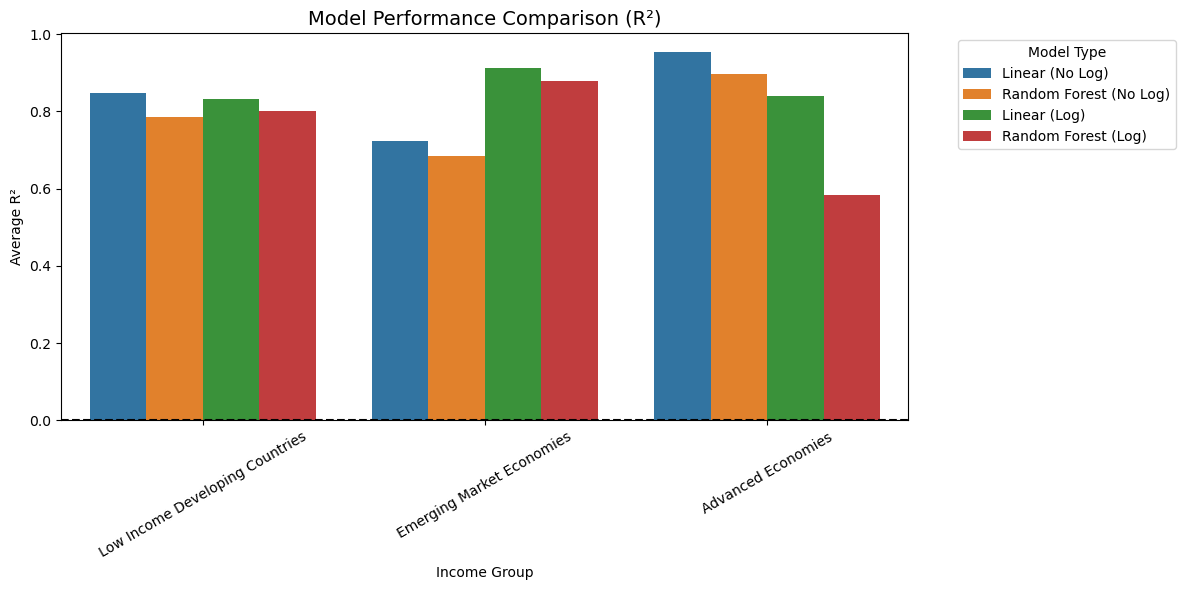

In [49]:
# Sort results nicely
df_plot = df_results.copy()
df_plot['Group'] = df_plot['Group'].astype(str)
df_plot['Model'] = df_plot['Model'].astype(str)

# Plot R2 comparison
plt.figure(figsize=(12,6))
sns.barplot(data=df_plot, x='Group', y='R2', hue='Model')
plt.title('Model Performance Comparison (R²)', fontsize=14)
plt.ylabel('Average R²')
plt.xlabel('Income Group')
plt.axhline(0, color='black', linestyle='--')
plt.legend(title='Model Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [50]:
best_models = df_results.sort_values('R2', ascending=False).groupby('Group').first().reset_index()
print(best_models)


                             Group            Model           MSE        R2
0               Advanced Economies  Linear (No Log)  34965.976043  0.954291
1        Emerging Market Economies     Linear (Log)      0.262733  0.912031
2  Low Income Developing Countries  Linear (No Log)   1776.152168  0.847105


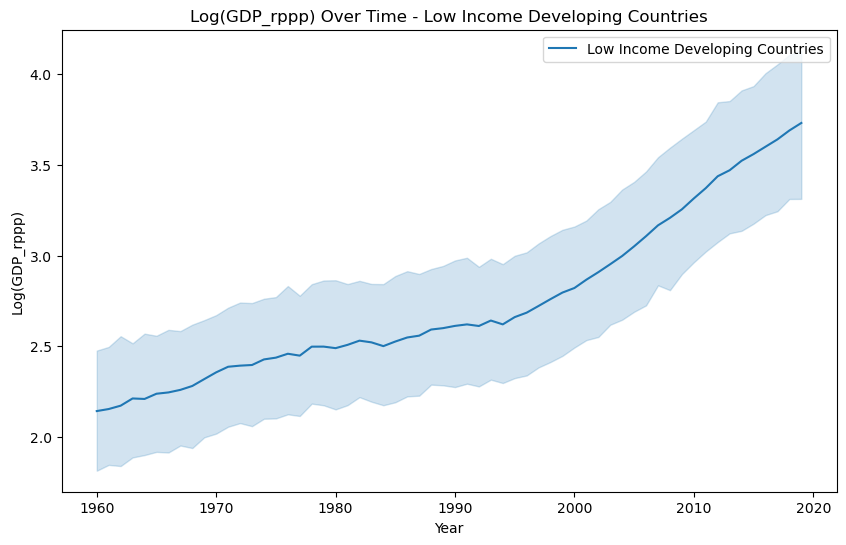

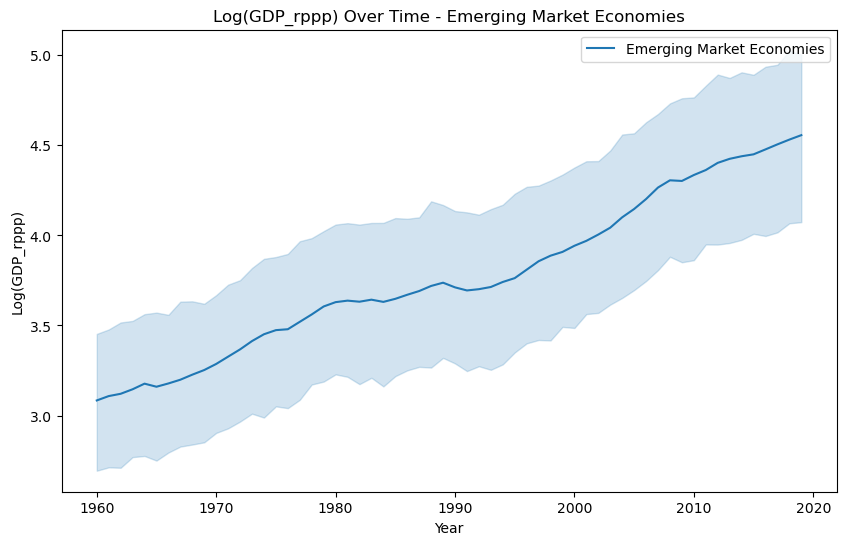

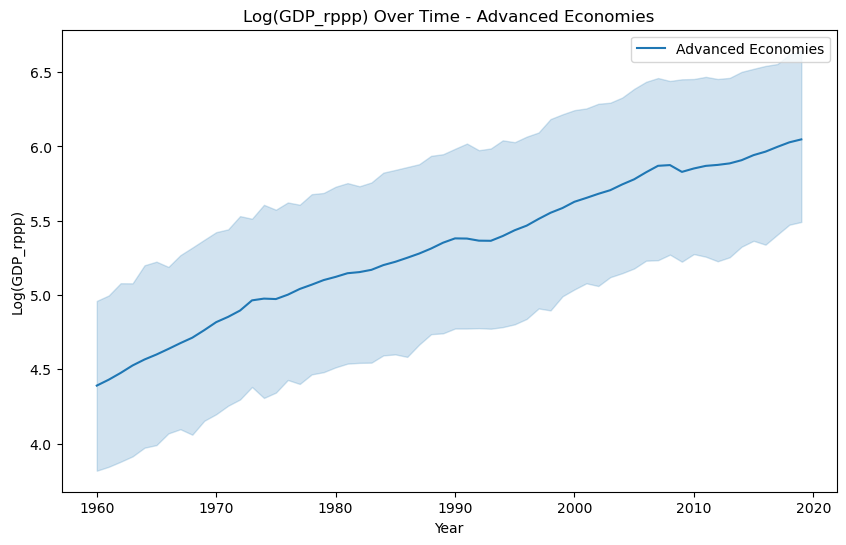

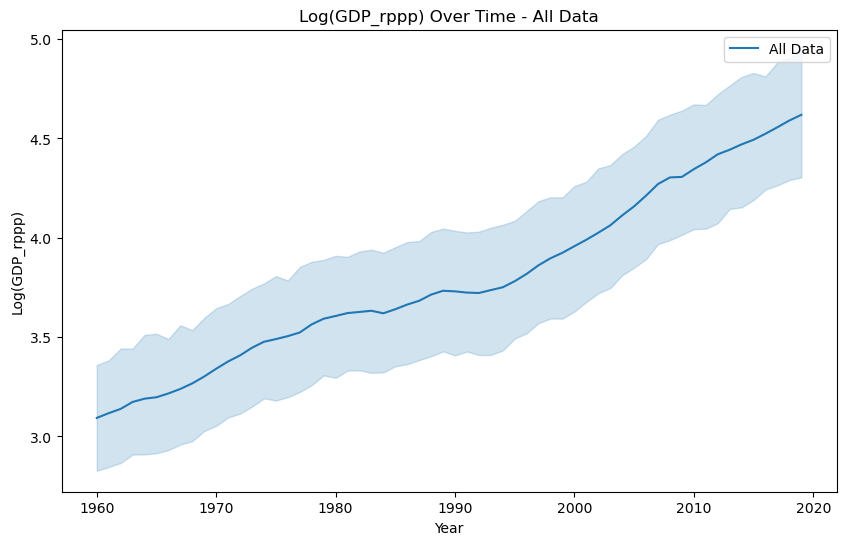

In [51]:
# Plot log(GDP_rppp) over time for each income group
for group, group_df in panel_1_groups.items():
    df = group_df.reset_index()
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='year', y=np.log1p(df['GDP_rppp']), label=group)
    plt.title(f'Log(GDP_rppp) Over Time - {group}')
    plt.xlabel('Year')
    plt.ylabel('Log(GDP_rppp)')
    plt.legend()
    plt.show()

# Plot for Panel 2
df = panel_2.reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='year', y=np.log1p(df['GDP_rppp']), label='All Data')
plt.title('Log(GDP_rppp) Over Time - All Data')
plt.xlabel('Year')
plt.ylabel('Log(GDP_rppp)')
plt.legend()
plt.show()

In [52]:
def plot_pdp(model, X_train, features, feature_names, model_label="Model"):
    """Plot Partial Dependence Plot (PDP) for given features."""
    if hasattr(model, "predict"):
        plt.figure(figsize=(14, 6))
        display = PartialDependenceDisplay.from_estimator(
            model, 
            X_train, 
            features=[feature_names.index(f) for f in features],
            feature_names=feature_names,
            kind="average",
            n_cols=2
        )
        plt.suptitle(f'Partial Dependence Plots - {model_label}', fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Model {model_label} does not support PDP.")


In [53]:

def plot_shap(model, X_train, feature_names, model_label="Model"):
    """Plot SHAP summary plot for Random Forest or Tree models."""
    if hasattr(model, "feature_importances_"):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train)

        shap.summary_plot(shap_values, X_train, feature_names=feature_names, plot_type="bar", show=True)
        shap.summary_plot(shap_values, X_train, feature_names=feature_names, show=True)
    else:
        print(f"Model {model_label} does not support SHAP plotting.")


In [54]:
def tune_random_forest(X, y, group_name="Group", random_state=42, n_iter=10):
    """Hyperparameter tuning Random Forest using RandomizedSearchCV."""
    print(f"\n==== Hyperparameter Tuning (Random Forest) for {group_name} ====")
    param_dist = {
        'max_depth': [4, 6, 8, 10, 12],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }
    rf = RandomForestRegressor(n_estimators=100, random_state=random_state)
    rs = RandomizedSearchCV(
        rf, param_distributions=param_dist,
        n_iter=n_iter, cv=TimeSeriesSplit(3), scoring='r2', n_jobs=-1, random_state=random_state
    )
    rs.fit(X, y)
    print("Best Params:", rs.best_params_)
    print(f"Best R² Score: {rs.best_score_:.4f}\n")
    return rs.best_estimator_

In [55]:
def auto_tune_all_groups(groups_data, log_features):
    """Auto tune Random Forest for all groups given in dictionary {'group_name': (X, y)}."""
    models = {}
    for group_name, (X, y) in groups_data.items():
        model = tune_random_forest(X, y, group_name=group_name)
        models[group_name] = model
    return models


In [56]:
def auto_pdp_shap_all_groups(tuned_models, groups_data, log_features):
    """Auto plot PDP and SHAP for each tuned model by group."""
    for group_name, model in tuned_models.items():
        print(f"\n==== PDP and SHAP for {group_name} ====")
        X, _ = groups_data[group_name]

        # Partial Dependence Plot
        plot_pdp(
            model,
            X,
            features=['log_priv_capital', 'log_labor_force'],
            feature_names=log_features,
            model_label=f"Random Forest Tuned - {group_name}"
        )

        # SHAP Values
        plot_shap(
            model,
            X,
            feature_names=log_features,
            model_label=f"Random Forest Tuned - {group_name}"
        )

In [57]:

simple_features = ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force']
log_features = [f'log_{col}' for col in simple_features]

# Low Income
print("Low Income Developing Countries:")
df_low = df_cleaned[df_cleaned['income_group'] == 'Low Income Developing Countries']
df_low_log = log_transform_features(df_low, simple_features, target_to_log='GDP_rppp')
model_rf_log_low, X_train_rf_log_low, y_train_rf_log_low = train_test_models(df_low_log, log_features, target='log_GDP_rppp', model_type='randomforest')

# Emerging Markets
print("\nEmerging Market Countries:")
df_emerging = df_cleaned[df_cleaned['income_group'] == 'Emerging Market Economies']
df_emerging_log = log_transform_features(df_emerging, simple_features, target_to_log='GDP_rppp')
model_rf_log_emerging, X_train_rf_log_emerging, y_train_rf_log_emerging = train_test_models(df_emerging_log, log_features, target='log_GDP_rppp', model_type='randomforest')

# Advanced Economies
print("\nAdvanced Economies Countries:")
df_advanced = df_cleaned[df_cleaned['income_group'] == 'Advanced Economies']
df_advanced_log = log_transform_features(df_advanced, simple_features, target_to_log='GDP_rppp')
model_rf_log_advanced, X_train_rf_log_advanced, y_train_rf_log_advanced = train_test_models(df_advanced_log, log_features, target='log_GDP_rppp', model_type='randomforest')


Low Income Developing Countries:
Randomforest Model Test Results:
Test MSE: 0.3564
Test R² : 0.7376


Emerging Market Countries:
Randomforest Model Test Results:
Test MSE: 0.1947
Test R² : 0.9581


Advanced Economies Countries:
Randomforest Model Test Results:
Test MSE: 0.1549
Test R² : 0.9487



**PLOTTING PDP & SHAP VALUE FOR THREE INCOME GROUPS**

<Figure size 1400x600 with 0 Axes>

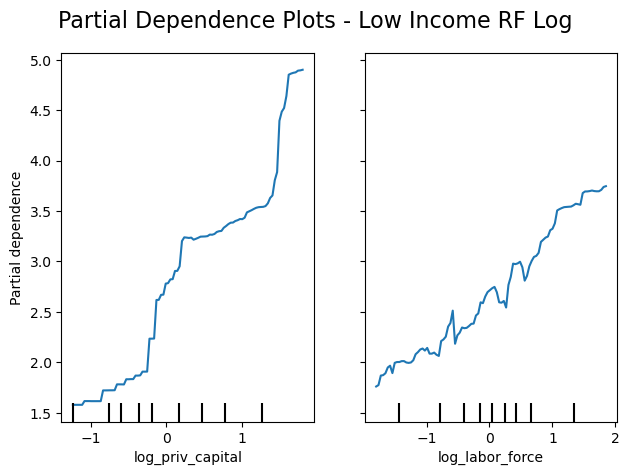

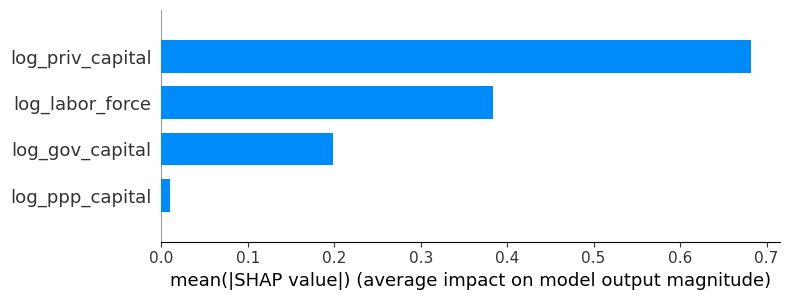

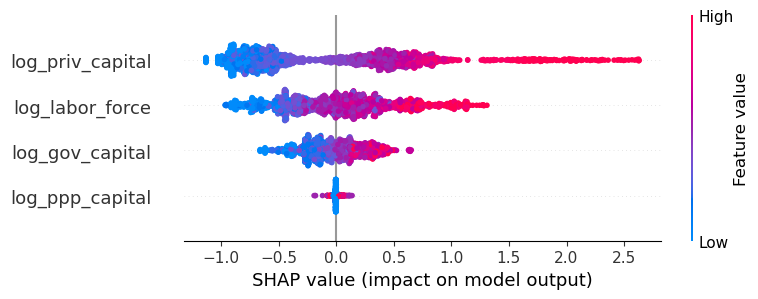

<Figure size 1400x600 with 0 Axes>

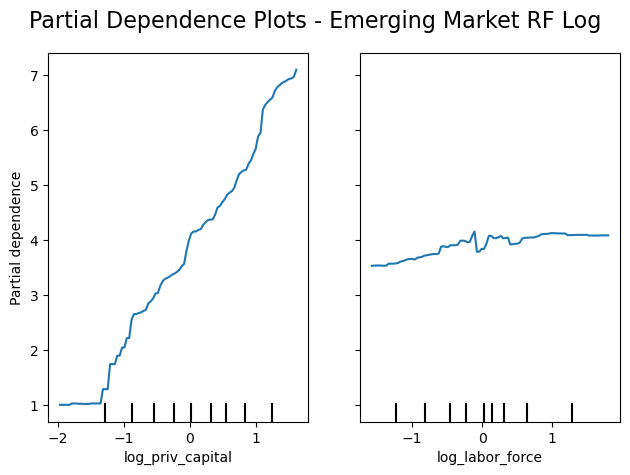

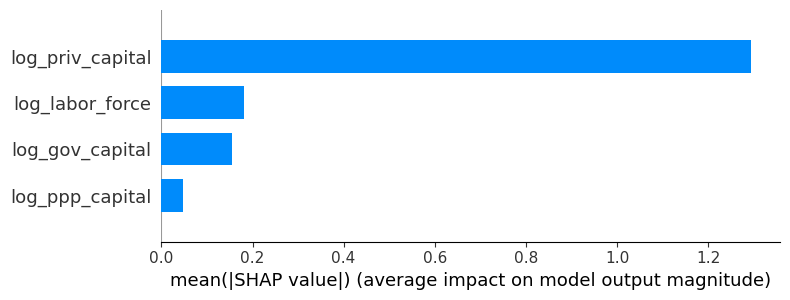

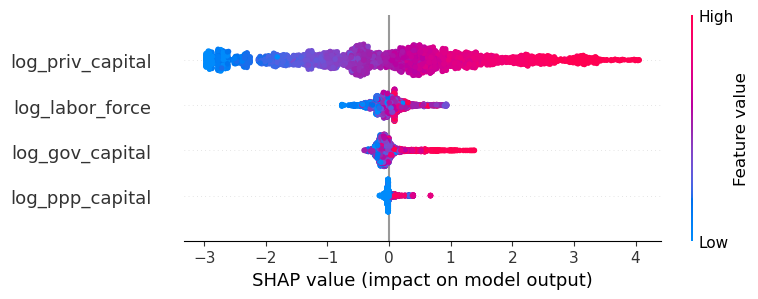

<Figure size 1400x600 with 0 Axes>

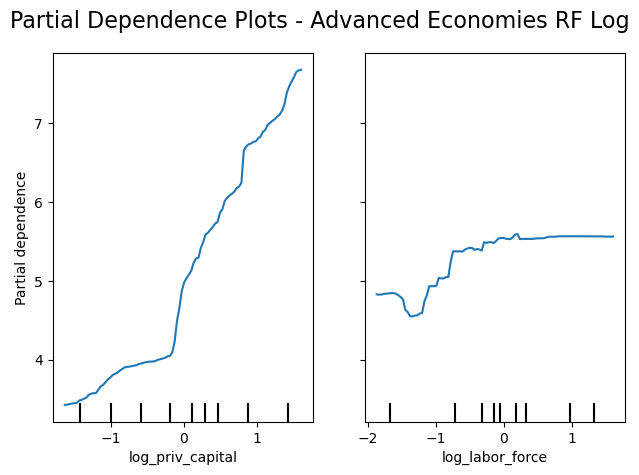

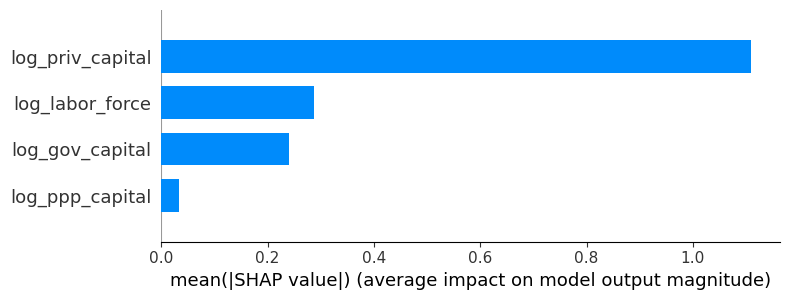

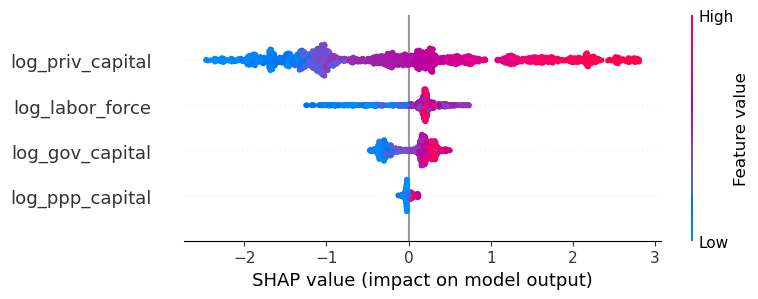

In [59]:
plot_pdp(model_rf_log_low, X_train_rf_log_low, features=['log_priv_capital', 'log_labor_force'], feature_names=log_features, model_label="Low Income RF Log")
plot_shap(model_rf_log_low, X_train_rf_log_low, feature_names=log_features, model_label="Low Income RF Log")

plot_pdp(model_rf_log_emerging, X_train_rf_log_emerging, features=['log_priv_capital', 'log_labor_force'], feature_names=log_features, model_label="Emerging Market RF Log")
plot_shap(model_rf_log_emerging, X_train_rf_log_emerging, feature_names=log_features, model_label="Emerging Market RF Log")

plot_pdp(model_rf_log_advanced, X_train_rf_log_advanced, features=['log_priv_capital', 'log_labor_force'], feature_names=log_features, model_label="Advanced Economies RF Log")
plot_shap(model_rf_log_advanced, X_train_rf_log_advanced, feature_names=log_features, model_label="Advanced Economies RF Log")


In [60]:
# Define feature columns
log_features = ['log_priv_capital', 'log_gov_capital', 'log_ppp_capital', 'log_labor_force']

# Prepare log-transformed datasets if not done yet
df_low_log = log_transform_features(df_low, ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force'], target_to_log='GDP_rppp')
df_emerging_log = log_transform_features(df_emerging, ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force'], target_to_log='GDP_rppp')
df_advanced_log = log_transform_features(df_advanced, ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force'], target_to_log='GDP_rppp')

# Create X and y for each group
X_low_log = df_low_log[log_features]
y_low_log = df_low_log['log_GDP_rppp']

X_emerging_log = df_emerging_log[log_features]
y_emerging_log = df_emerging_log['log_GDP_rppp']

X_advanced_log = df_advanced_log[log_features]
y_advanced_log = df_advanced_log['log_GDP_rppp']



In [61]:
# Hyperparameter Tuning
groups_data = {
    'Low Income Developing Countries': (X_low_log, y_low_log),
    'Emerging Market Economies': (X_emerging_log, y_emerging_log),
    'Advanced Economies': (X_advanced_log, y_advanced_log)
}

# Call Auto Tune
tuned_models = auto_tune_all_groups(groups_data, log_features)



==== Hyperparameter Tuning (Random Forest) for Low Income Developing Countries ====
Best Params: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 12}
Best R² Score: 0.8142


==== Hyperparameter Tuning (Random Forest) for Emerging Market Economies ====
Best Params: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10}
Best R² Score: 0.9283


==== Hyperparameter Tuning (Random Forest) for Advanced Economies ====
Best Params: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 8}
Best R² Score: 0.9359




==== PDP and SHAP for Low Income Developing Countries ====


<Figure size 1400x600 with 0 Axes>

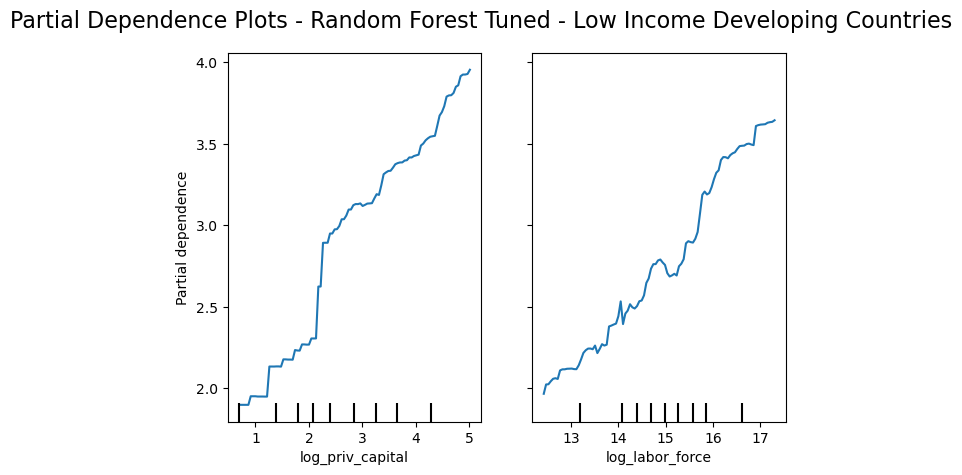

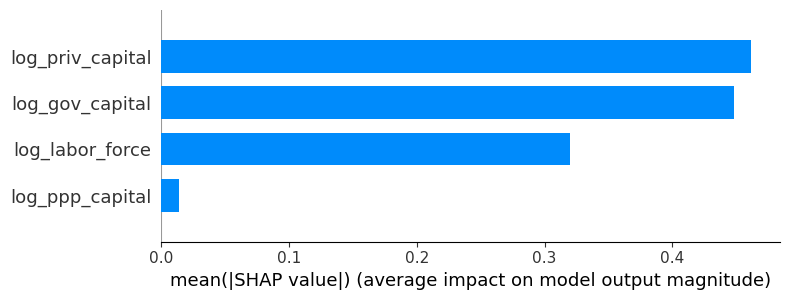

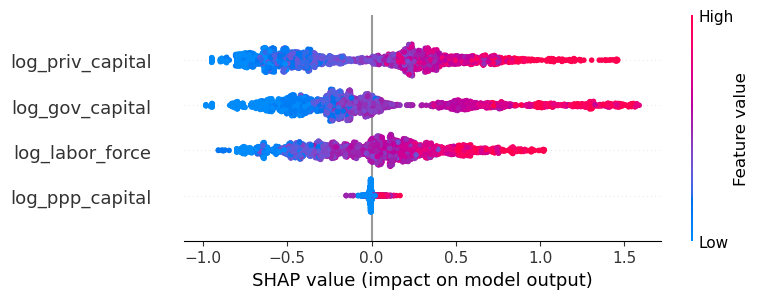


==== PDP and SHAP for Emerging Market Economies ====


<Figure size 1400x600 with 0 Axes>

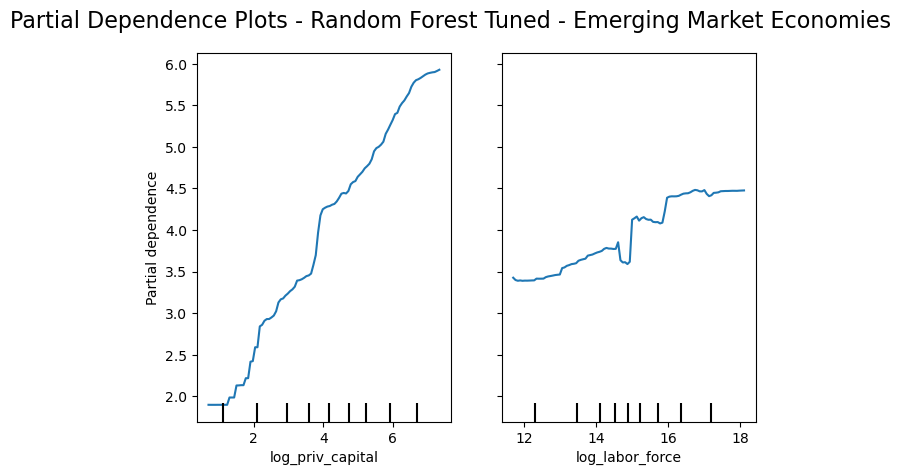

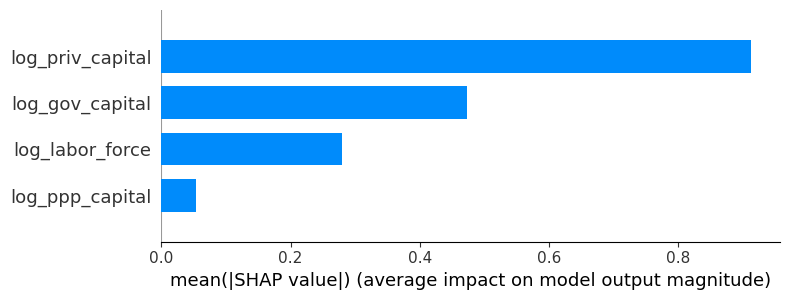

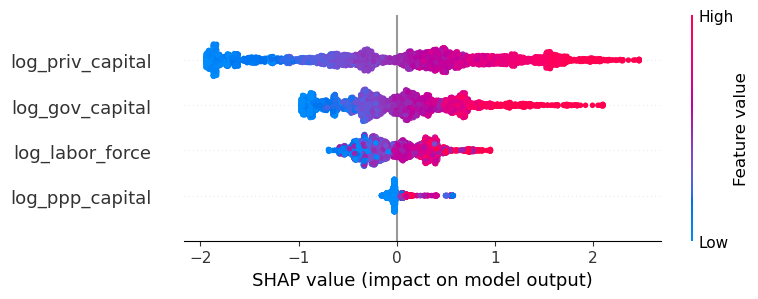


==== PDP and SHAP for Advanced Economies ====


<Figure size 1400x600 with 0 Axes>

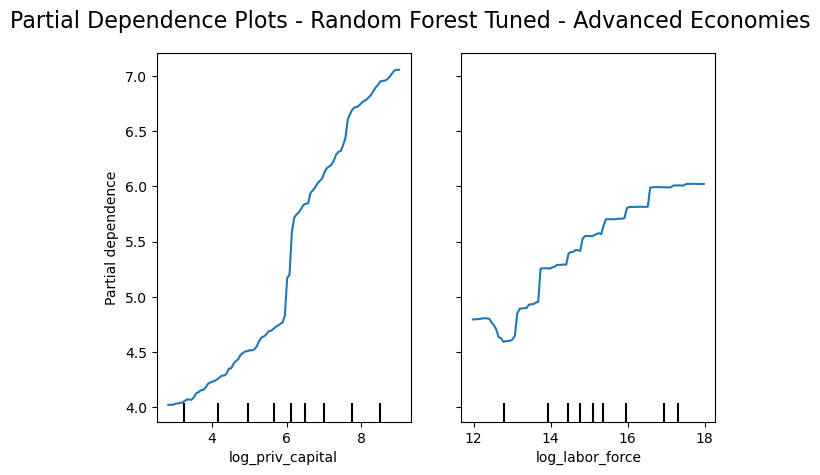

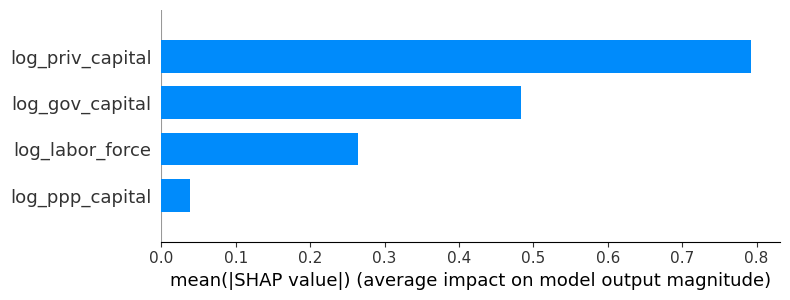

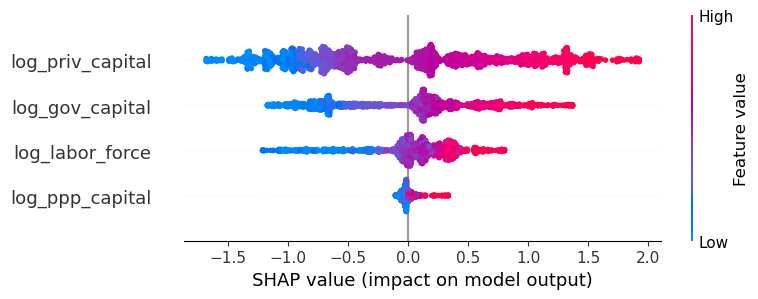

In [62]:
auto_pdp_shap_all_groups(tuned_models, groups_data, log_features)


**XGBOOST**

In [64]:
def train_and_cv_xgb(X, y, group_label="Group"):
    """Train XGBoost model, evaluate test set, and perform 5-fold TimeSeries CV."""
    print(f"\n===== XGBoost Training and Evaluation for {group_label} =====")

    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train XGBoost
    model_xgb = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    )
    model_xgb.fit(X_train, y_train)

    # Test evaluation
    y_pred = model_xgb.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Test MSE: {mse:.4f}")
    print(f"Test R² : {r2:.4f}")

    # 5-Fold CV
    avg_mse, avg_r2 = cross_validate_models(model_xgb, X_train, y_train, cv_type='timeseries', n_splits=5)

    return model_xgb


In [65]:
model_xgb_low = train_and_cv_xgb(X_low_log, y_low_log, group_label="Low Income Developing Countries")
model_xgb_emerging = train_and_cv_xgb(X_emerging_log, y_emerging_log, group_label="Emerging Market Economies")
model_xgb_advanced = train_and_cv_xgb(X_advanced_log, y_advanced_log, group_label="Advanced Economies")



===== XGBoost Training and Evaluation for Low Income Developing Countries =====
Test MSE: 0.3837
Test R² : 0.7175
Fold 1: MSE=0.0673, R²=0.9412
Fold 2: MSE=0.1356, R²=0.9007
Fold 3: MSE=0.2535, R²=0.8085
Fold 4: MSE=0.4878, R²=0.5232
Fold 5: MSE=0.1734, R²=0.9043

Average MSE: 0.2235
Average R² : 0.8156


===== XGBoost Training and Evaluation for Emerging Market Economies =====
Test MSE: 0.2030
Test R² : 0.9564
Fold 1: MSE=0.6023, R²=0.8446
Fold 2: MSE=0.3718, R²=0.8969
Fold 3: MSE=0.1775, R²=0.9612
Fold 4: MSE=0.4205, R²=0.8076
Fold 5: MSE=0.1870, R²=0.9225

Average MSE: 0.3518
Average R² : 0.8866


===== XGBoost Training and Evaluation for Advanced Economies =====
Test MSE: 0.1851
Test R² : 0.9387
Fold 1: MSE=1.9836, R²=-0.2619
Fold 2: MSE=0.2466, R²=0.9521
Fold 3: MSE=0.0550, R²=0.9820
Fold 4: MSE=0.7461, R²=0.2297
Fold 5: MSE=0.0744, R²=0.8662

Average MSE: 0.6211
Average R² : 0.5536



**Panel Data Analysis on R packages**

In [168]:
def run_panel_model(panel_df, group_label="All Panel", selected_country=None):
    print(f"\n===== Panel Modeling for {group_label} =====")

    panel_df = panel_df.reset_index() if not {'country', 'year'}.issubset(panel_df.index.names) else panel_df

    for col in ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force', 'GDP_rppp']:
        if f'log1p_{col}' not in panel_df.columns:
            panel_df[f'log1p_{col}'] = np.log1p(panel_df[col])

    df_panel = panel_df.set_index(['country', 'year']).sort_index()

    y = df_panel['log1p_GDP_rppp']
    X = sm.add_constant(df_panel[['log1p_priv_capital', 'log1p_gov_capital', 'log1p_ppp_capital', 'log1p_labor_force']])

    fe = PanelOLS(y, X, entity_effects=True).fit()
    country_fe = fe.estimated_effects.groupby('country')['estimated_effects'].mean().reset_index().rename(columns={'estimated_effects': 'country_fixed_effect'})

    re = RandomEffects(y, X).fit()
    residuals = re.resids
    if isinstance(residuals, pd.Series):
        residuals = residuals.to_frame(name='residuals')
    country_re = residuals.groupby('country')['residuals'].mean().reset_index().rename(columns={'residuals': 'country_random_effect'})

    sigma2_e = re.variance_decomposition['Residual']
    sigma2_u = re.variance_decomposition['Effects']
    panel_sizes = df_panel.groupby('country').size()
    weight = sigma2_u / (sigma2_u + sigma2_e / panel_sizes)

    country_re['country_random_effect'] = country_re['country_random_effect'] * weight.reindex(country_re['country']).values

    country_effects_df = country_re.merge(country_fe, on='country', how='left')

    if selected_country:
        result = country_effects_df[country_effects_df['country'] == selected_country]
        if not result.empty:
            print(f"\nEffects for {selected_country} in {group_label}:")
            display(result[['country', 'country_random_effect', 'country_fixed_effect']])
        else:
            print(f"\n{selected_country} not found in {group_label}.")



In [170]:
def run_panel_model_all(df_cleaned):
    """Run panel modeling for all countries and separately for each income group."""
    print("\n===== Panel Modeling for All Data (Combined and By Income Groups) =====")

    panel_2 = df_cleaned.sort_values(['country', 'year']).set_index(['country', 'year'])

    panel_1_groups = {
        group: df_cleaned[df_cleaned['income_group'] == group]
               .sort_values(['country', 'year'])
               .set_index(['country', 'year'])
        for group in df_cleaned['income_group'].unique()
    }

    # First Display all available countries
    available_countries = df_cleaned['country'].unique()
    print("\nAvailable countries:")
    print(sorted(available_countries))

    # One time input
    selected_country = input("\nEnter a country name to scan (or 'exit' to skip): ")
    if selected_country.lower() == 'exit':
        print("Skipping country-specific analysis.")
        return

    # Run for All countries
    run_panel_model(panel_2.reset_index(), group_label="All Countries (No Grouping)", selected_country=selected_country)

    # Then run for each group
    for group_name, panel_df in panel_1_groups.items():
        run_panel_model(panel_df.reset_index(), group_label=group_name, selected_country=selected_country)


In [67]:
# def run_panel_model(panel_df, group_label="All Panel"):
#     """Run Fixed Effects and Random Effects models for the panel data."""
#     print(f"\n===== Panel Modeling for {group_label} =====")

#     panel_df = panel_df.reset_index() if not {'country', 'year'}.issubset(panel_df.index.names) else panel_df

#     # Add log1p columns if not present
#     for col in ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force', 'GDP_rppp']:
#         if f'log1p_{col}' not in panel_df.columns:
#             panel_df[f'log1p_{col}'] = np.log1p(panel_df[col])

#     df_panel = panel_df.set_index(['country', 'year']).sort_index()

#     y = df_panel['log1p_GDP_rppp']
#     X = df_panel[['log1p_priv_capital', 'log1p_gov_capital', 'log1p_ppp_capital', 'log1p_labor_force']]
#     X = sm.add_constant(X)

#     # Fixed Effects
#     fe = PanelOLS(y, X, entity_effects=True)
#     fe_res = fe.fit()
#     print("===== Fixed Effects Results =====")
#     print(fe_res)

#     # Random Effects
#     re = RandomEffects(y, X)
#     re_res = re.fit()
#     print("\n===== Random Effects Results =====")
#     print(re_res)

#     # Hausman Comparison
#     cmp = compare({'Fixed': fe_res, 'Random': re_res})
#     print("\n===== Hausman Test Comparison =====")
#     print(cmp)

In [68]:
# For Low Income Developing Countries
low_income_df = (
    df_cleaned[df_cleaned['income_group'] == 'Low Income Developing Countries']
    .sort_values(['country', 'year'])
    .set_index(['country', 'year'])
)
run_panel_model(low_income_df.reset_index(), group_label="Low Income Developing Countries")

# For Emerging Market Economies
emerging_df = (
    df_cleaned[df_cleaned['income_group'] == 'Emerging Market Economies']
    .sort_values(['country', 'year'])
    .set_index(['country', 'year'])
)
run_panel_model(emerging_df.reset_index(), group_label="Emerging Market Economies")

# For Advanced Economies
advanced_df = (
    df_cleaned[df_cleaned['income_group'] == 'Advanced Economies']
    .sort_values(['country', 'year'])
    .set_index(['country', 'year'])
)
run_panel_model(advanced_df.reset_index(), group_label="Advanced Economies")



===== Panel Modeling for Low Income Developing Countries =====
===== Fixed Effects Results =====
                          PanelOLS Estimation Summary                           
Dep. Variable:         log1p_GDP_rppp   R-squared:                        0.8110
Estimator:                   PanelOLS   R-squared (Between):              0.8200
No. Observations:                2715   R-squared (Within):               0.8110
Date:                Sat, Apr 26 2025   R-squared (Overall):              0.8209
Time:                        03:17:16   Log-likelihood                    19.332
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2858.2
Entities:                          46   P-value                           0.0000
Avg Obs:                       59.022   Distribution:                  F(4,2665)
Min Obs:                       36.000                                           
Max Obs:   

C:\Users\Sushil\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\Sushil\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows wit

In [69]:
# # For All Countries (no grouping)
panel_2 = df_cleaned.sort_values(['country', 'year']).set_index(['country', 'year'])
run_panel_model(panel_2.reset_index(), group_label="All Countries (No Grouping)")



===== Panel Modeling for All Countries (No Grouping) =====
===== Fixed Effects Results =====
                          PanelOLS Estimation Summary                           
Dep. Variable:         log1p_GDP_rppp   R-squared:                        0.8089
Estimator:                   PanelOLS   R-squared (Between):              0.8943
No. Observations:                8652   R-squared (Within):               0.8089
Date:                Sat, Apr 26 2025   R-squared (Overall):              0.8911
Time:                        03:17:16   Log-likelihood                   -71.788
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8985.7
Entities:                         155   P-value                           0.0000
Avg Obs:                       55.819   Distribution:                  F(4,8493)
Min Obs:                       11.000                                           
Max Obs:       

C:\Users\Sushil\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [132]:
# def run_panel_model_all(df_cleaned):
#     """Run panel modeling for all countries and separately for each income group."""
#     print("\n===== Panel Modeling for All Data (Combined and By Income Groups) =====")

#     # Create panel 2 (all countries)
#     panel_2 = df_cleaned.sort_values(['country', 'year']).set_index(['country', 'year'])

#     # Create panel 1 groups
#     panel_1_groups = {
#         group: df_cleaned[df_cleaned['income_group'] == group]
#                .sort_values(['country', 'year'])
#                .set_index(['country', 'year'])
#         for group in df_cleaned['income_group'].unique()
#     }

#     # Run for full panel
#     run_panel_model(panel_2.reset_index(), group_label="All Countries (No Grouping)")

#     # Run separately for each income group
#     for group_name, panel_df in panel_1_groups.items():
#         run_panel_model(panel_df.reset_index(), group_label=group_name)
# run_panel_model_all(df_cleaned)

In [176]:
run_panel_model_all(df_cleaned)


===== Panel Modeling for All Data (Combined and By Income Groups) =====

Available countries:
['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia, The', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'I


Enter a country name to scan (or 'exit' to skip):  Nepal



===== Panel Modeling for All Countries (No Grouping) =====

Effects for Nepal in All Countries (No Grouping):


C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


,country,country_random_effect,country_fixed_effect
104,Nepal,-0.01271,-0.226854



===== Panel Modeling for Low Income Developing Countries =====

Effects for Nepal in Low Income Developing Countries:


,country,country_random_effect,country_fixed_effect
30,Nepal,0.004621,0.040629


C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)



===== Panel Modeling for Emerging Market Economies =====

Nepal not found in Emerging Market Economies.

===== Panel Modeling for Advanced Economies =====

Nepal not found in Advanced Economies.


C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [130]:
# import numpy as np
# import pandas as pd
# import statsmodels.api as sm
# from linearmodels.panel import PanelOLS, RandomEffects

# # ——————————————————————————————————————————————
# # 0) Log-transform the key variables on final_df
# for col in ['GDP_rppp', 'gov_capital', 'priv_capital', 'ppp_capital', 'labor_force']:
#     final_df[f'log1p_{col}'] = np.log1p(final_df[col])

# # 1) Build a proper panel-indexed DataFrame
# panel = (
#     final_df
#     .set_index(['country', 'year'])
#     .sort_index()
# )

# y = panel['log1p_GDP_rppp']
# X = sm.add_constant(panel[[
#     'log1p_priv_capital',
#     'log1p_gov_capital',
#     'log1p_ppp_capital',
#     'log1p_labor_force'
# ]])

# # ——————————————————————————————————————————————
# # 2) Country fixed effects (one-way)
# fe_country_res = PanelOLS(y, X, entity_effects=True).fit()

# # Extract entity effects
# ent = fe_country_res.estimated_effects
# country_fe = (
#     ent
#     .groupby('country')['estimated_effects']
#     .mean()
#     .reset_index()
#     .rename(columns={'estimated_effects': 'country_fixed_effect'})
# )

# # ——————————————————————————————————————————————
# # 3) Year fixed effects (one-way)
# fe_time_res = PanelOLS(y, X, time_effects=True).fit()

# # Extract time effects
# tim = fe_time_res.estimated_effects
# time_fe = (
#     tim
#     .groupby('year')['estimated_effects']
#     .mean()
#     .reset_index()
#     .rename(columns={'estimated_effects': 'time_fixed_effect'})
# )

# # ——————————————————————————————————————————————
# # 4) Random effects (per country)
# re_res = RandomEffects(y, X).fit()

# # Manual computation of random effects
# residuals = re_res.resids

# # If residuals is a Series, convert to DataFrame
# if isinstance(residuals, pd.Series):
#     residuals = residuals.to_frame(name='residuals')
# else:
#     residuals = residuals.rename(columns={residuals.columns[0]: 'residuals'})

# # Compute random effects
# country_re = (
#     residuals
#     .groupby('country')['residuals']
#     .mean()
#     .reset_index()
#     .rename(columns={'residuals': 'country_random_effect'})
# )

# # Get variance components
# sigma2_e = re_res.variance_decomposition['Residual']
# sigma2_u = re_res.variance_decomposition['Effects']

# # Compute weights
# panel_sizes = panel.groupby('country').size()
# weight = sigma2_u / (sigma2_u + sigma2_e / panel_sizes)

# # Apply weights
# country_re['country_random_effect'] = country_re['country_random_effect'] * weight.reindex(country_re['country']).values

# # ——————————————————————————————————————————————
# # 5) Merge them back onto the original final_df
# df_out = (
#     final_df
#     .merge(country_re, on='country', how='left')
#     .merge(country_fe, on='country', how='left')
#     .merge(time_fe, on='year', how='left')
# )

# # 6) Create a DataFrame for country effects (one row per country)
# country_effects_df = country_re.merge(country_fe, on='country', how='left')[['country', 'country_random_effect', 'country_fixed_effect']]

# # 7) Create a DataFrame for time effects (one row per year)
# time_effects_df = time_fe[['year', 'time_fixed_effect']]

# # 8) Create a DataFrame with selected columns for full results (for filtering)
# result_df = df_out[['country', 'year', 'country_random_effect', 'country_fixed_effect', 'time_fixed_effect']]

# # 9) Print the country effects DataFrame
# print("\nCountry Effects (Random and Fixed Effects, one row per country):")
# display(country_effects_df)

# # 10) Print the time effects DataFrame
# print("\nTime Effects (Fixed Effects, one row per year, applies to all countries):")
# display(time_effects_df)

# # 11) Function to print results for a specific country (from full results)
# def print_country_results(df, country_name):
#     """
#     Print results for a specific country.
    
#     Parameters:
#     df (pd.DataFrame): DataFrame containing the results
#     country_name (str): Name of the country to filter
#     """
#     try:
#         country_data = df[df['country'] == country_name]
#         if country_data.empty:
#             print(f"No data found for country: {country_name}")
#         else:
#             print(f"\nFull Results for {country_name} (including year-specific time effects):")
#             print(country_data)
#     except KeyError:
#         print("Error: 'country' column not found in DataFrame")

# # 12) Prompt user to print results for a specific country
# country_to_print = input("Enter the country name to print full results (e.g., United States): ")
# print_country_results(result_df, country_to_print)

# # 13) List available countries
# print("\nAvailable countries in the dataset:")
# print(result_df['country'].unique())


Country Effects (Random and Fixed Effects, one row per country):


C:\Users\Sushil\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\Sushil\anaconda3\Lib\site-packages\linearmodels\panel\model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


,country,country_random_effect,country_fixed_effect
0,Afghanistan,-0.038182,-0.532658
1,Albania,-0.000910,0.068352
2,Algeria,-0.010897,-0.194063
3,Angola,-0.042107,-0.593383
4,Antigua and Barbuda,-0.090133,-1.193817
...,...,...,...
150,United States,-0.038702,-0.741480
151,Uruguay,-0.000545,0.089690
152,Uzbekistan,0.073791,0.863725
153,Zambia,0.010284,0.131390



Time Effects (Fixed Effects, one row per year, applies to all countries):


,year,time_fixed_effect
0,1960,0.017584
1,1961,0.021418
2,1962,0.021498
3,1963,0.023472
4,1964,0.034568
5,1965,0.030145
6,1966,0.020728
7,1967,0.019374
8,1968,0.019759
9,1969,0.032956


Enter the country name to print full results (e.g., United States):  Nepal



Full Results for Nepal (including year-specific time effects):
     country  year  country_random_effect  country_fixed_effect  \
6133   Nepal  1960               -0.01271             -0.226854   
6134   Nepal  1961               -0.01271             -0.226854   
6135   Nepal  1962               -0.01271             -0.226854   
6136   Nepal  1963               -0.01271             -0.226854   
6137   Nepal  1964               -0.01271             -0.226854   
6138   Nepal  1965               -0.01271             -0.226854   
6139   Nepal  1966               -0.01271             -0.226854   
6140   Nepal  1967               -0.01271             -0.226854   
6141   Nepal  1968               -0.01271             -0.226854   
6142   Nepal  1969               -0.01271             -0.226854   
6143   Nepal  1970               -0.01271             -0.226854   
6144   Nepal  1971               -0.01271             -0.226854   
6145   Nepal  1972               -0.01271             -0.226854  